In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple

from sklearn.inspection import permutation_importance
import lightgbm as lgb

from utils.functions import calculate_mean_performance_sector, prepare_train_test_data, return_learning_curve, create_results_df, equitative_return, acumulative_year_earnings

In [3]:
df_final = pd.read_feather("../data/final_data.feather")

### Creation of the Baseline
The baseline is created to have a reference to compare the performance of the model. The baseline is created by using the n_aseets(the baseline will use the same n assets that us), that performed the best in the last year. The baseline will be the average of the returns of the n_assets.

In [ ]:
df_final['1year_price_variation'] = (df_final['1year_price'] - df_final['price']) / df_final['price']
df_final['Baseline'] = df_final.groupby('asset_num')['1year_price_variation'].shift(4)

In [6]:
def calculate_sp500_return() -> float:
    sp500 = pd.read_csv("../data/initial_data/SP500_TR.csv")
    sp500['date'] = pd.to_datetime(sp500['date']).dt.to_period('Q')
    sp500 = sp500.groupby('date').apply(lambda group: group.loc[group['date'].idxmax()]).reset_index(drop=True)
    sp500['1year_sp500_return'] = (sp500['SP500'].shift(-4) - sp500['SP500']) / sp500['SP500']
    sp500 = sp500[sp500['date'] < '2023Q4']
    return sp500[['date', '1year_sp500_return']]

sp500 = calculate_sp500_return()
sp500.head()

/var/folders/9s/g205zh4n1qxctfk8d568b41c0000gn/T/ipykernel_5865/2740055011.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sp500 = sp500.groupby('date').apply(lambda group: group.loc[group['date'].idxmax()]).reset_index(drop=True)


,date,1year_sp500_return
0,2005Q1,0.057696
1,2005Q2,0.127167
2,2005Q3,0.091986
3,2005Q4,0.106072
4,2006Q1,0.157942


In [7]:
df_final = df_final.merge(sp500, left_on='quarter', right_on='date', how='left').drop(columns='date')
df_final['asset_return_diff_sp500'] = df_final['1year_price_variation'] - df_final['1year_sp500_return']
df_final['asset_return_gt_sp500'] = df_final['asset_return_diff_sp500'] > 0

### Creation of more features
Creating new features related to the EV or other features and deleting original ones, p.e.: ebit, ebitda, net income, revenue.
That's because we though fundamental features without any transformation couldn't be comparable between companies of different sizes.

In [8]:
df_final['EV_EBITDA'] = df_final['ev'] / df_final['ebitda']
df_final['EV_EBIT'] = df_final['ev'] / df_final['ebit']
df_final['P_B_ratio'] = df_final['price'] / (df_final['T_assets'] - df_final['T_debt'])

df_final['Debt_to_Equity'] = df_final['T_debt'] / (df_final['T_assets'] - df_final['T_debt'])
df_final['Net_Debt_to_EBITDA'] = df_final['net_debt'] / df_final['ebitda']

df_final['Asset_Turnover'] = df_final['T_rev'] / df_final['T_assets']
df_final['Cash_Conversion_Ratio'] = df_final['cash'] / df_final['T_rev']

We also decided to create new features related to the sector of each company, with that we can see the performance of the company in relation to the sector.

In [9]:
sector_performance_cols = ['EV_EBITDA', 'EV_EBIT', 'P_B_ratio', 'Debt_to_Equity', 'Net_Debt_to_EBITDA', 'Asset_Turnover', 'Cash_Conversion_Ratio']

In [10]:
df_final = calculate_mean_performance_sector(df_final, sector_performance_cols)

In [11]:
df_final.columns

Index(['quarter', 'asset_num', 'price', 'cap_ex', 'cash', 'dil_shares', 'ebit',
       'ebitda', 'net_inc', 'survivor', 'T_assets', 'T_debt', 'T_rev',
       'sector', '1year_price', 'new_sector', 'ebit_marg', 'ebitda_marg',
       'net_marg', 'ROA', 'ROE', 'debts_assets', 'net_debt', 'cash_ratio',
       'net_income_per_share', 'price_earning_ratio', 'ev',
       '1year_price_variation', 'Baseline', '1year_sp500_return',
       'asset_return_diff_sp500', 'asset_return_gt_sp500', 'EV_EBITDA',
       'EV_EBIT', 'P_B_ratio', 'Debt_to_Equity', 'Net_Debt_to_EBITDA',
       'Asset_Turnover', 'Cash_Conversion_Ratio', 'EV_EBITDA_mean_sector_diff',
       'EV_EBIT_mean_sector_diff', 'P_B_ratio_mean_sector_diff',
       'Debt_to_Equity_mean_sector_diff',
       'Net_Debt_to_EBITDA_mean_sector_diff',
       'Asset_Turnover_mean_sector_diff',
       'Cash_Conversion_Ratio_mean_sector_diff'],
      dtype='object')

In [12]:
basic_features = ['cap_ex', 'cash', 'ebit', 'ebitda', 'net_inc', 'T_assets', 'T_debt', 'T_rev','dil_shares','net_debt','ev']
df_final = df_final.drop(columns=basic_features, errors='ignore')

# Handle missing or infinite values
df_final.replace([np.inf, -np.inf], np.nan, inplace=True)

In [13]:
info_cols = ['asset_num','quarter','sector','survivor','price','1year_price','prices_std','1year_price_variation','1year_sp500_return','asset_return_diff_sp500']
target_col = 'asset_return_gt_sp500'
df_final['new_sector'] = df_final['new_sector'].astype('category')

feature_cols = [col for col in df_final.columns if col not in info_cols + [target_col]]
print(df_final[feature_cols].isna().sum())

new_sector                                   0
ebit_marg                                 2741
ebitda_marg                               2796
net_marg                                   387
ROA                                        405
ROE                                        405
debts_assets                               396
cash_ratio                                1673
net_income_per_share                       564
price_earning_ratio                        565
Baseline                                  3455
EV_EBITDA                                 3007
EV_EBIT                                   2954
P_B_ratio                                  396
Debt_to_Equity                             396
Net_Debt_to_EBITDA                        2846
Asset_Turnover                             405
Cash_Conversion_Ratio                      440
EV_EBITDA_mean_sector_diff                3007
EV_EBIT_mean_sector_diff                  2954
P_B_ratio_mean_sector_diff                 396
Debt_to_Equit

### Creation of the dataset partitions to train the model

In [14]:
df_final['quarter'] = df_final['quarter'].astype('str')
df_final = df_final[~df_final['quarter'].isin(['2005Q1','2005Q2','2005Q3','2005Q4'])]

In [15]:
unique_quarters = df_final['quarter'].astype('str').unique()
unique_quarters

array(['2006Q1', '2006Q2', '2006Q3', '2006Q4', '2007Q1', '2007Q2',
       '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3', '2008Q4',
       '2009Q1', '2009Q2', '2009Q3', '2009Q4', '2010Q1', '2010Q2',
       '2010Q3', '2010Q4', '2011Q1', '2011Q2', '2011Q3', '2011Q4',
       '2012Q1', '2012Q2', '2012Q3', '2012Q4', '2013Q1', '2013Q2',
       '2013Q3', '2013Q4', '2014Q1', '2014Q2', '2014Q3', '2014Q4',
       '2015Q1', '2015Q2', '2015Q3', '2015Q4', '2016Q1', '2016Q2',
       '2016Q3', '2016Q4', '2017Q1', '2017Q2', '2017Q3', '2017Q4',
       '2018Q1', '2018Q2', '2018Q3', '2018Q4', '2019Q1', '2019Q2',
       '2019Q3', '2019Q4', '2020Q1', '2020Q2', '2020Q3', '2020Q4',
       '2021Q1', '2021Q2', '2021Q3', '2021Q4', '2022Q1', '2022Q2',
       '2022Q3', '2022Q4', '2023Q1', '2023Q2', '2023Q3'], dtype=object)

In [16]:
window_size = 12
datasets = prepare_train_test_data(df_final, 'quarter', feature_cols, target_col, window_size=window_size)

### Searching for the best hyperparameters

In [17]:
# This code is commented to avoid running it by mistake but it is left here to show the results
# for n_estimators in [50, 100]:
#     for learning_rate in [0.01, 0.1]:
#         for num_leaves in [32, 64]:
#             for path_smooth in [0.1, 0.5]:
#                 params_lgb = {
#                     'metric': 'logloss',
#                     'random_state': 1,
#                     'verbose': 0,
#                     'n_estimators': n_estimators,
#                     'learning_rate': learning_rate,
#                     'num_leaves': num_leaves,
#                     'path_smooth': path_smooth
#                 }
                
#                 models_list = {}
#                 results_list = {}
#                 predictions_list = {}
#                 compute_importance = True
#                 permut_importances_list = {}
#                 categorical_features = ['new_sector']

#                 for i in range(len(datasets)):
#                     test_quarter = unique_quarters[i + window_size]
#                     #print(f"Training model to test quarter: {test_quarter}")

#                     X_train, y_train, X_test, y_test = datasets[unique_quarters[i+window_size]]

#                     eval_result = {}

#                     model = lgb.LGBMClassifier(**params_lgb)

#                     model.fit(
#                         X_train, y_train,
#                         categorical_feature=categorical_features,
#                         eval_set=[(X_test, y_test), (X_train, y_train)],
#                         eval_metric='logloss',
#                         callbacks=[lgb.record_evaluation(eval_result=eval_result)]
#                     )
                    
#                     results_list[(test_quarter)] = eval_result


#                 test_lc = return_learning_curve(results_list,"valid_0")
#                 train_lc = return_learning_curve(results_list,"training")

#                 train_lc['n_trees_cat'] = pd.Categorical(train_lc['n_trees'], categories=sorted(train_lc['n_trees'].unique()))
#                 test_lc['n_trees_cat'] = pd.Categorical(test_lc['n_trees'], categories=sorted(test_lc['n_trees'].unique()))



#                 fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))

#                 sns.boxplot(data=train_lc, x='n_trees_cat', y='norm_binary_logloss', color='blue', ax=ax1)
#                 ax1.hlines(0, 0, len(train_lc['n_trees'].unique()), color='red', linestyle='--')
#                 ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
#                 ax1.set_title('Training Learning Curve')

#                 sns.boxplot(data=test_lc, x='n_trees_cat', y='norm_binary_logloss', color='blue', ax=ax2)
#                 ax2.hlines(0, 0, len(test_lc['n_trees'].unique()), color='red', linestyle='--')
#                 ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)
#                 ax2.set_title('Test Learning Curve')

#                 plt.suptitle(f'Learning Curves with n_est={n_estimators},lr={learning_rate},n_leaves={num_leaves},path={path_smooth}', fontsize=16, y=1.02)

#                 plt.tight_layout()  
#                 plt.show()

After comparing the learning curves, we choose the model with Lr = 0.01, n_leaves = 64, path_smooth = 0.1 or 0.5, and n_estimators = 100.

In [18]:
params_lgb = {
    'objective': 'binary',
    'metric': 'logloss',
    'random_state': 1,
    'verbose': 0,
    'n_estimators': 100,
    'learning_rate': 0.01,
    'num_leaves': 64,
    'path_smooth': 0.5
}



models_list = {}
results_list = {}
predictions_list = {}
compute_importance = True
permut_importances_list = {}
categorical_features = ['new_sector']

for i in range(len(datasets)):
    test_quarter = unique_quarters[i + window_size]
    print(f"Training model to test quarter: {test_quarter}")
    
    X_train, y_train, X_test, y_test = datasets[unique_quarters[i+window_size]]
    
    eval_result = {}
    
    model = lgb.LGBMClassifier(**params_lgb)
    
    model.fit(
        X_train, y_train,
        categorical_feature=categorical_features,
        eval_set=[(X_test, y_test), (X_train, y_train)],
        eval_metric='logloss',
        callbacks=[lgb.record_evaluation(eval_result=eval_result)]
    )
    
    if compute_importance:
        r = permutation_importance(model, X_test, y_test, n_repeats=15, random_state=0)
        feature_names = X_test.columns
        df_permutation_importance = pd.DataFrame({'importance': r.importances_mean, 'feature': feature_names})
    else:
        df_permutation_importance = pd.DataFrame()
    
    
    models_list[(test_quarter)] = model
    results_list[(test_quarter)] = eval_result
    predictions_list[(test_quarter)] = model.predict_proba(X_test)[:,1]
    permut_importances_list[(test_quarter)] = df_permutation_importance

Training model to test quarter: 2009Q1
Training model to test quarter: 2009Q2
Training model to test quarter: 2009Q3
Training model to test quarter: 2009Q4
Training model to test quarter: 2010Q1
Training model to test quarter: 2010Q2
Training model to test quarter: 2010Q3
Training model to test quarter: 2010Q4
Training model to test quarter: 2011Q1
Training model to test quarter: 2011Q2
Training model to test quarter: 2011Q3
Training model to test quarter: 2011Q4
Training model to test quarter: 2012Q1
Training model to test quarter: 2012Q2
Training model to test quarter: 2012Q3
Training model to test quarter: 2012Q4
Training model to test quarter: 2013Q1
Training model to test quarter: 2013Q2
Training model to test quarter: 2013Q3
Training model to test quarter: 2013Q4
Training model to test quarter: 2014Q1
Training model to test quarter: 2014Q2
Training model to test quarter: 2014Q3
Training model to test quarter: 2014Q4
Training model to test quarter: 2015Q1
Training model to test qu

In [169]:
test_lc = return_learning_curve(results_list,"valid_0")
train_lc = return_learning_curve(results_list,"training")

train_lc['n_trees_cat'] = pd.Categorical(train_lc['n_trees'], categories=sorted(train_lc['n_trees'].unique()))
test_lc['n_trees_cat'] = pd.Categorical(test_lc['n_trees'], categories=sorted(test_lc['n_trees'].unique()))

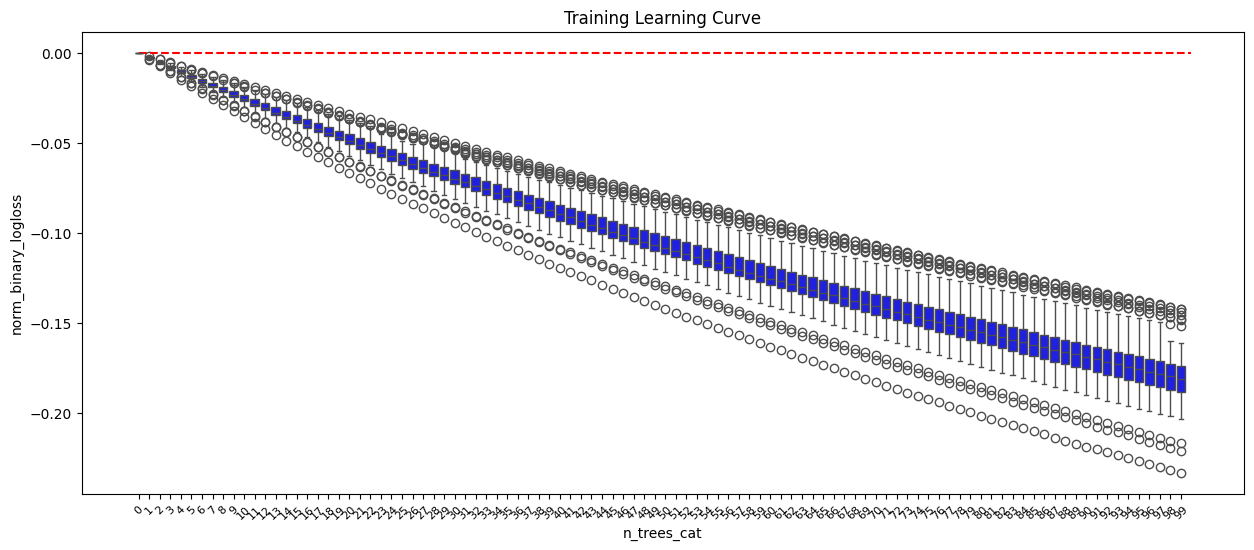

In [170]:
plt.subplots(figsize=(15, 6))
sns.boxplot(data=train_lc, x='n_trees_cat', y='norm_binary_logloss', color='blue')
plt.hlines(0, 0, len(test_lc['n_trees'].unique()), color='red', linestyle='--')
plt.xticks(rotation=45, fontsize=8)
plt.title('Training Learning Curve')
plt.show()

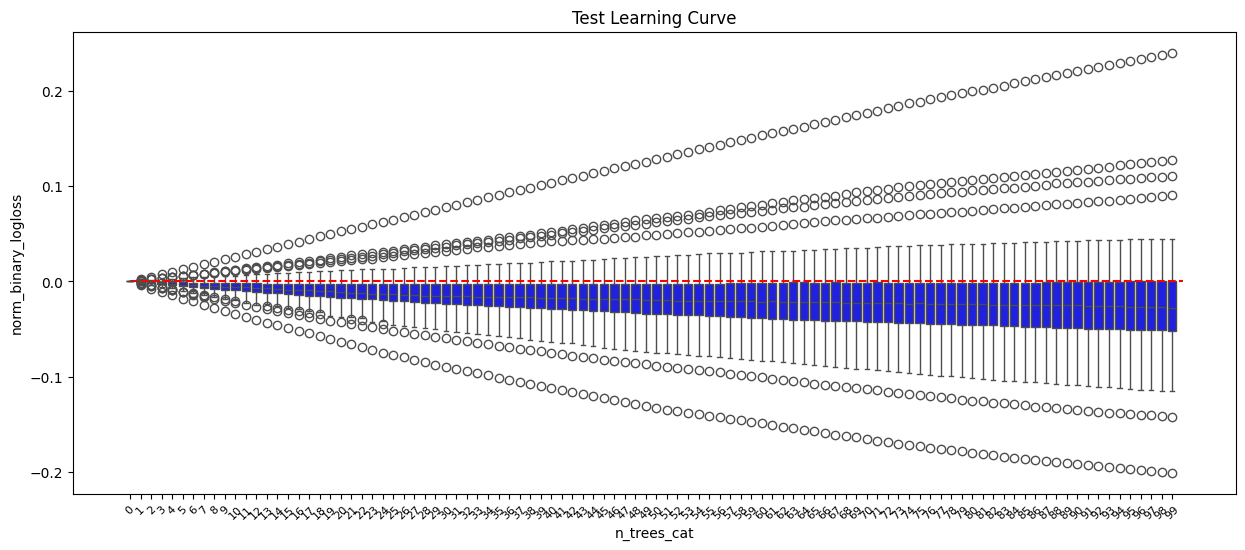

In [171]:
plt.subplots(figsize=(15, 6))
sns.boxplot(data=test_lc, x='n_trees_cat', y='norm_binary_logloss', color='blue')
plt.hlines(0, 0, len(test_lc['n_trees'].unique()), color='red', linestyle='--')
plt.xticks(rotation=45, fontsize=8)
plt.title('Test Learning Curve')
plt.show()

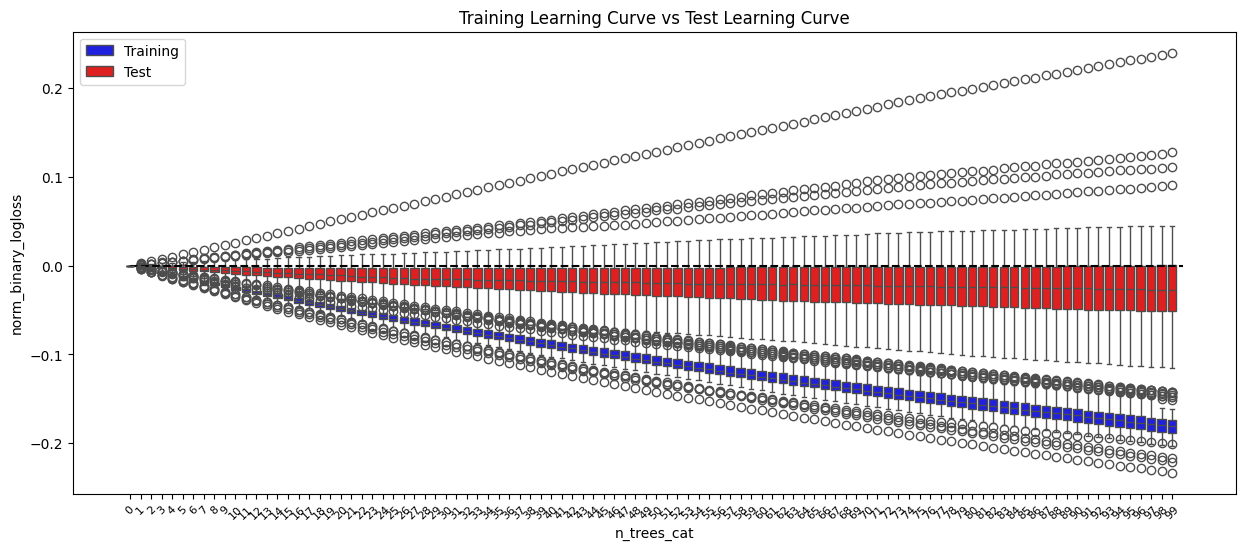

In [172]:
plt.subplots(figsize=(15, 6))
sns.boxplot(data=train_lc, x='n_trees_cat', y='norm_binary_logloss', color='blue', label='Training')
sns.boxplot(data=test_lc, x='n_trees_cat', y='norm_binary_logloss', color='red', label='Test')
plt.hlines(0, 0, len(test_lc['n_trees'].unique()), color='black', linestyle='--')
plt.xticks(rotation=45, fontsize=8)
plt.title('Training Learning Curve vs Test Learning Curve')
plt.legend()
plt.show()

In [19]:
importance_dfs = []

# Generate a DataFrame for each quarter with the permutation importances
for quarter, df_imp in permut_importances_list.items():
    df_imp['quarter'] = quarter
    df_imp['importance'] = df_imp['importance']
    importance_dfs.append(df_imp)

df_importances = pd.concat(importance_dfs, ignore_index=True)

df_importances

,importance,feature,quarter
0,-6.612686e-03,new_sector,2009Q1
1,-1.349528e-03,ebit_marg,2009Q1
2,3.700743e-17,ebitda_marg,2009Q1
3,-2.699055e-04,net_marg,2009Q1
4,-2.699055e-04,ROA,2009Q1
...,...,...,...
1470,8.333333e-03,P_B_ratio_mean_sector_diff,2023Q3
1471,8.736559e-03,Debt_to_Equity_mean_sector_diff,2023Q3
1472,3.360215e-03,Net_Debt_to_EBITDA_mean_sector_diff,2023Q3
1473,2.220446e-17,Asset_Turnover_mean_sector_diff,2023Q3


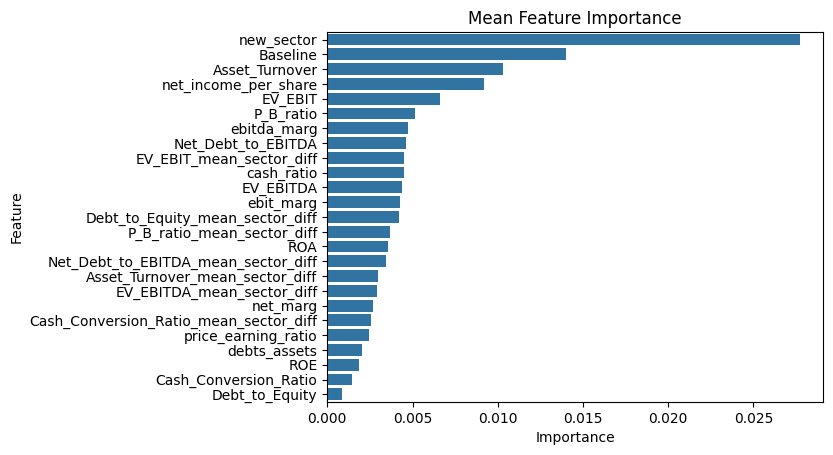

In [20]:
df_importances_mean = df_importances.groupby('feature')['importance'].mean().sort_values(ascending=False)
sns.barplot(x=df_importances_mean, y=df_importances_mean.index)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Mean Feature Importance')
plt.show()

In [55]:
df_importances_sorted = df_importances.sort_values(by=['quarter','importance'], ascending=[True,False]).reset_index(drop=True)
df_importances_sorted["rank"] = df_importances_sorted.groupby(["quarter"]).cumcount()
r_all_permutation_importances = df_importances_sorted[df_importances_sorted["rank"]<3]

In [56]:
# Group least important features in "others"
least10 = r_all_permutation_importances.groupby('feature').agg({'importance':'sum'}).reset_index()
least10 = least10.sort_values('importance', ascending=False)[10:]

In [57]:
# Change the name of the least important features to "others"
r_all_permutation_importances.loc[r_all_permutation_importances['feature'].isin(least10['feature']), 'feature'] = 'others'

# For the repeated "others" sum the importance
r_all_permutation_importances = r_all_permutation_importances.groupby(['quarter','feature']).agg({'importance':'sum'}).reset_index()
r_all_permutation_importances

,quarter,feature,importance
0,2009Q1,Baseline,0.041296
1,2009Q1,net_income_per_share,0.004993
2,2009Q1,others,0.007018
3,2009Q2,Baseline,0.032311
4,2009Q2,others,0.012270
...,...,...,...
163,2023Q2,new_sector,0.094567
164,2023Q2,others,0.022669
165,2023Q3,P_B_ratio,0.018280
166,2023Q3,ebitda_marg,0.011559


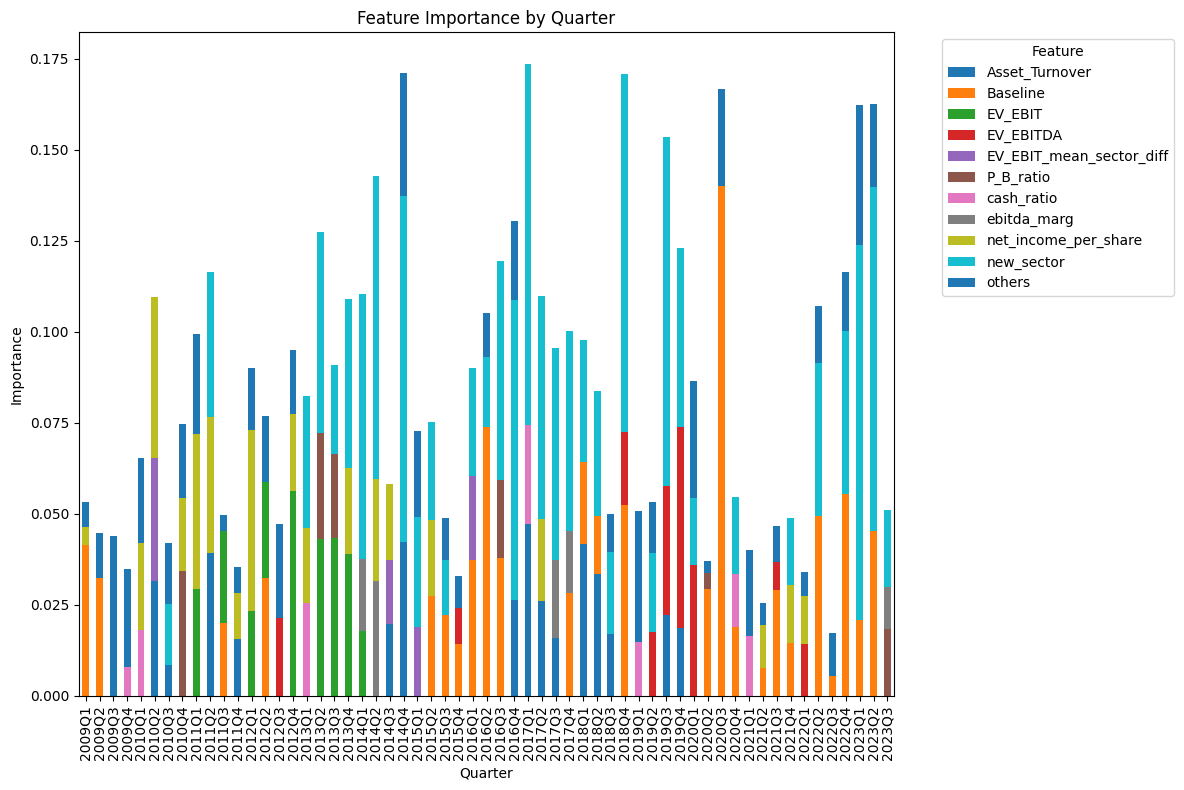

In [58]:
pivot_df = r_all_permutation_importances.pivot(index="quarter", columns="feature", values="importance")

pivot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 8),
)
plt.xlabel("Quarter")
plt.ylabel("Importance")
plt.title("Feature Importance by Quarter")
plt.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Comparing predictions with SP500

In [177]:
def calculate_returns(sector_df:bool=False,n_assets:int = 20,column:str='asset_return_diff_sp500') -> pd.DataFrame:
    prediction_returns = []
    baseline_returns = []
    sector_returns = []
    sector_list = []
    quarter_list = []
    for i in range(len(datasets)):
        quarter = unique_quarters[i+window_size] 
        if sector_df:
            df = create_results_df(df_final,predictions_list, quarter,True,column)
            for sector in df['new_sector'].unique():
                df_sector = df[df['new_sector'] == sector]
                return_sector = df_sector[column].mean()
                sector_returns.append(return_sector)
                sector_list.append(sector)
                return_prediction_equitative = equitative_return(df_sector, n_assets,column=column)
                prediction_returns.append(return_prediction_equitative)
                return_baseline = df_sector.sort_values('Baseline', ascending=False).head(n_assets)[column].mean()
                baseline_returns.append(return_baseline)
                
                quarter_list.append(quarter)
        else:
            df = create_results_df(df_final,predictions_list, quarter,False,column)
            return_prediction_equitative = equitative_return(df, n_assets,column)
            return_baseline = df.sort_values('Baseline', ascending=False).head(n_assets)[column].mean()
            prediction_returns.append(return_prediction_equitative)
            baseline_returns.append(return_baseline)
    
    if sector_df:
        return pd.DataFrame({'quarter': quarter_list, 'sector': sector_list,
                         'prediction_return': prediction_returns,  
                         'baseline_return': baseline_returns, 'sector_return': sector_returns})
    else: 
        return pd.DataFrame({'quarter': unique_quarters[window_size:], 
                         'prediction_return': prediction_returns,  
                         'baseline_return': baseline_returns})

### Returns per quarter prediction vs SP500
At the graph, we can see for each quarter the difference between the return of the prediction and the return of the SP500. We take also the difference between Baseline and SP500 to compare with the prediction model.

In [178]:
n_assets = 20
df_returns_quarters = calculate_returns(n_assets=n_assets,column = "asset_return_diff_sp500")
df_returns_quarters['Q'] = df_returns_quarters['quarter'].str[4:]

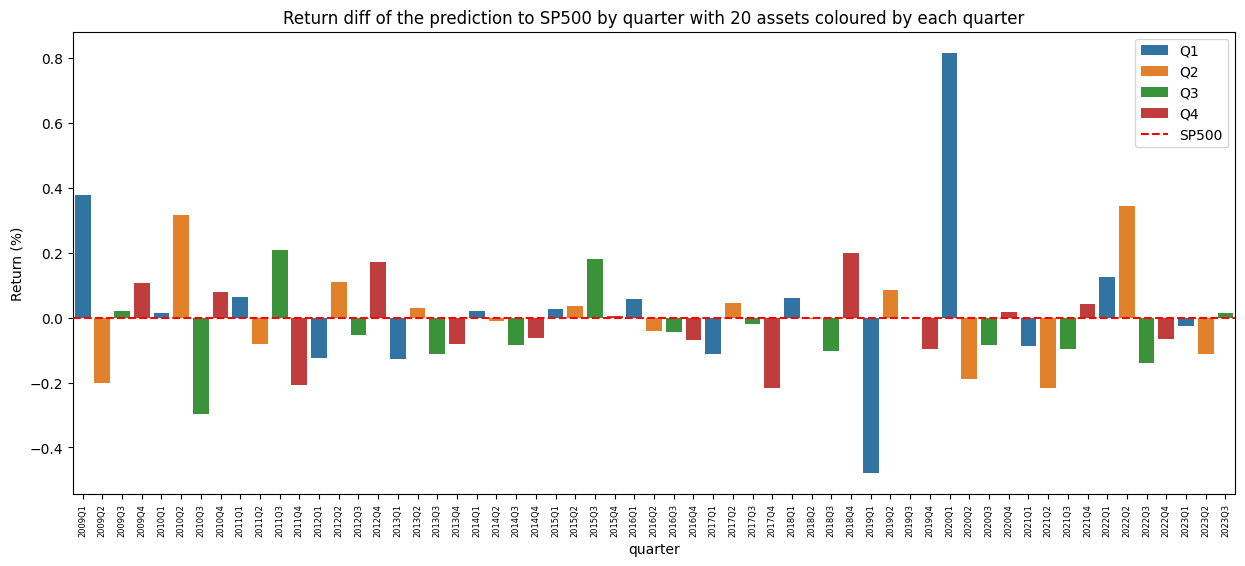

In [179]:
plt.subplots(figsize=(15, 6))
sns.barplot(data=df_returns_quarters, x='quarter', y='prediction_return',hue = 'Q')
plt.axhline(y=0.0, color='r', linestyle='--', label='SP500')
plt.title(f'Return diff of the prediction to SP500 by quarter with {n_assets} assets coloured by each quarter')
plt.ylabel('Return (%)')
plt.xticks(rotation=90, fontsize=6)
plt.legend()
plt.show()

Percentage of returns of the predictions that performed better than the SP500: 

In [180]:
(df_returns_quarters['prediction_return'] > 0).mean()

0.4576271186440678

### Comparing predictions versus the return of the market for each sector

For each quarter, and sector, we will calculate the return of the model for the top 20 assets compared to the return of the sector

In [181]:
n_assets = 5
sector_returns = calculate_returns(sector_df=True,n_assets=n_assets,column='asset_return_diff_sp500')

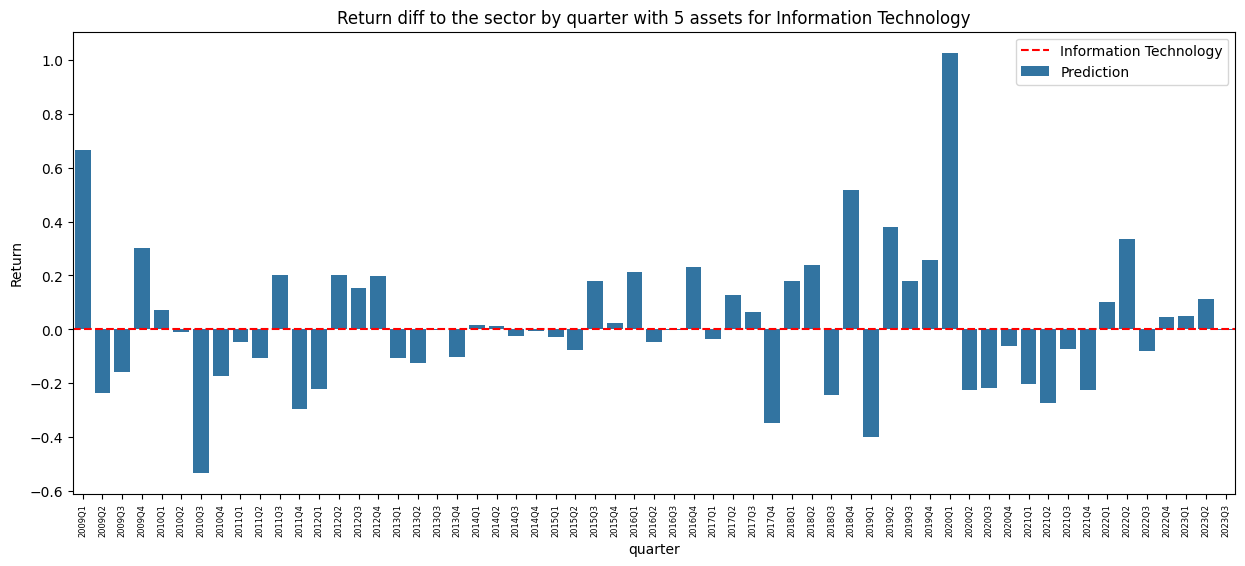

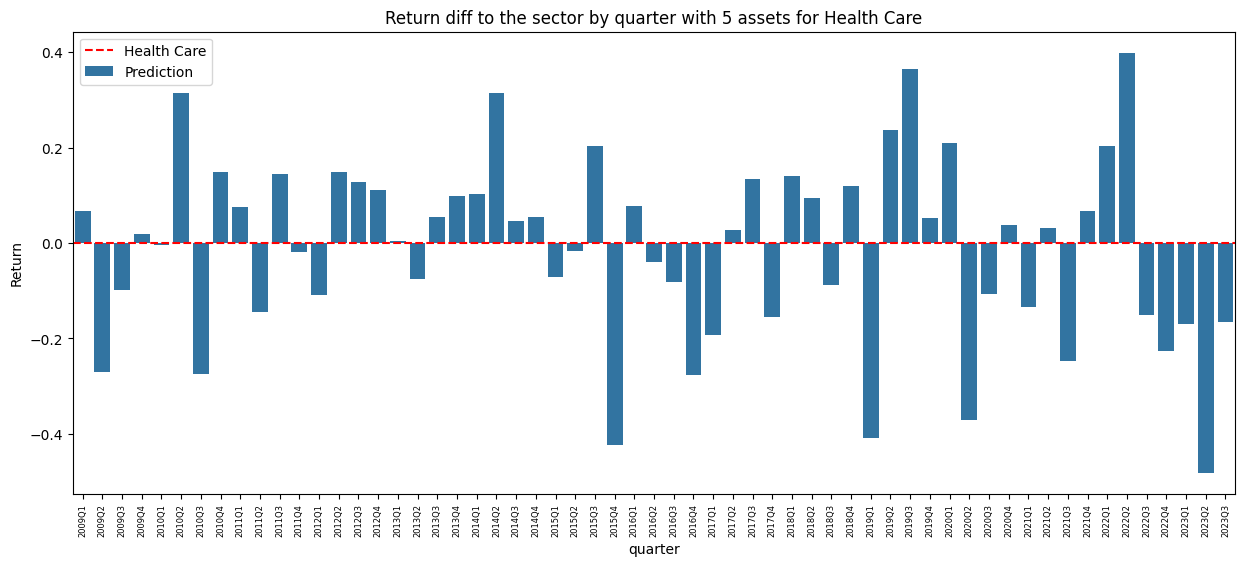

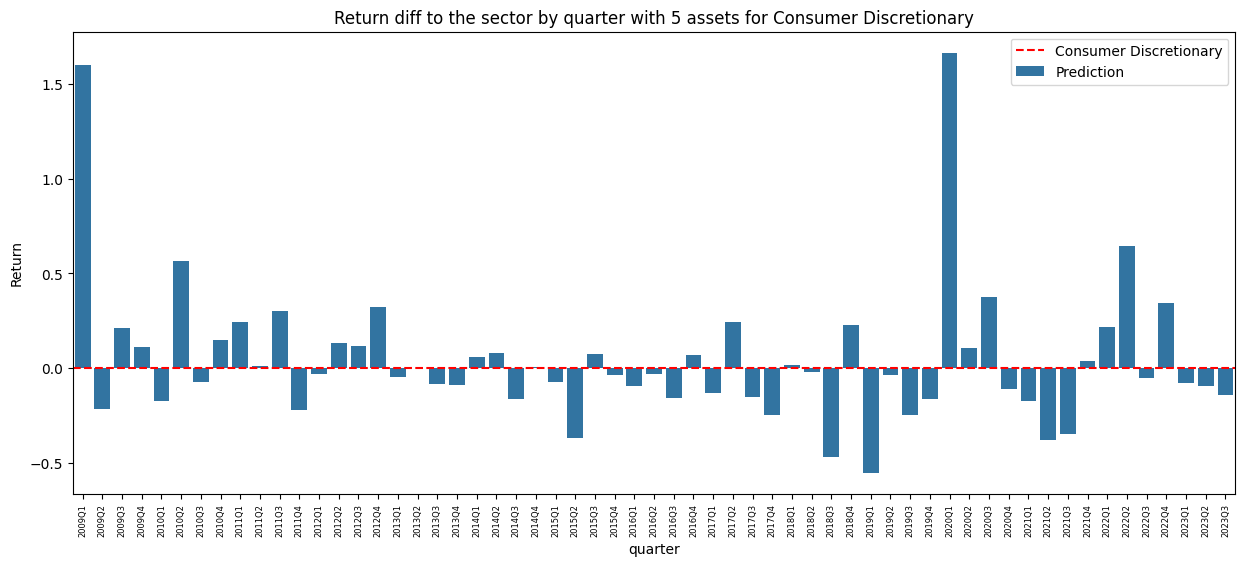

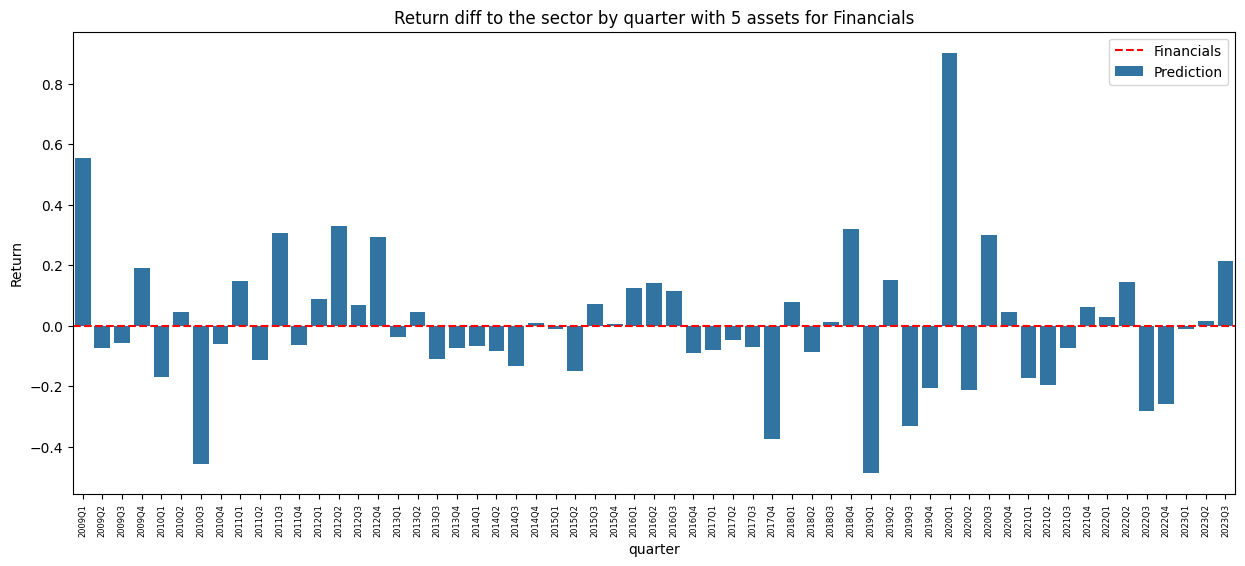

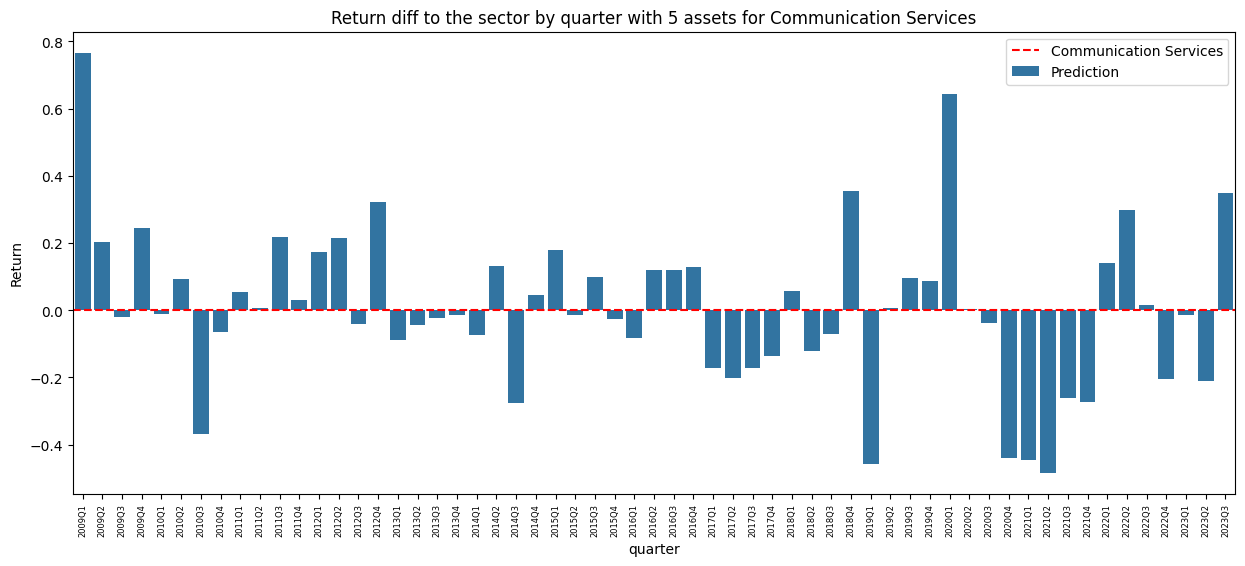

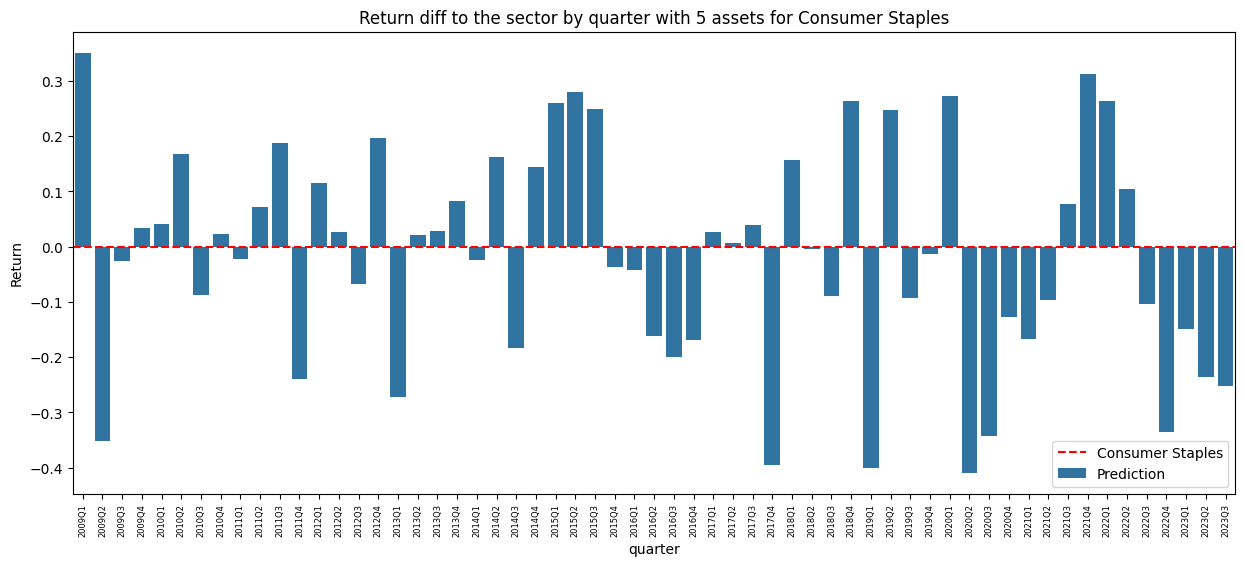

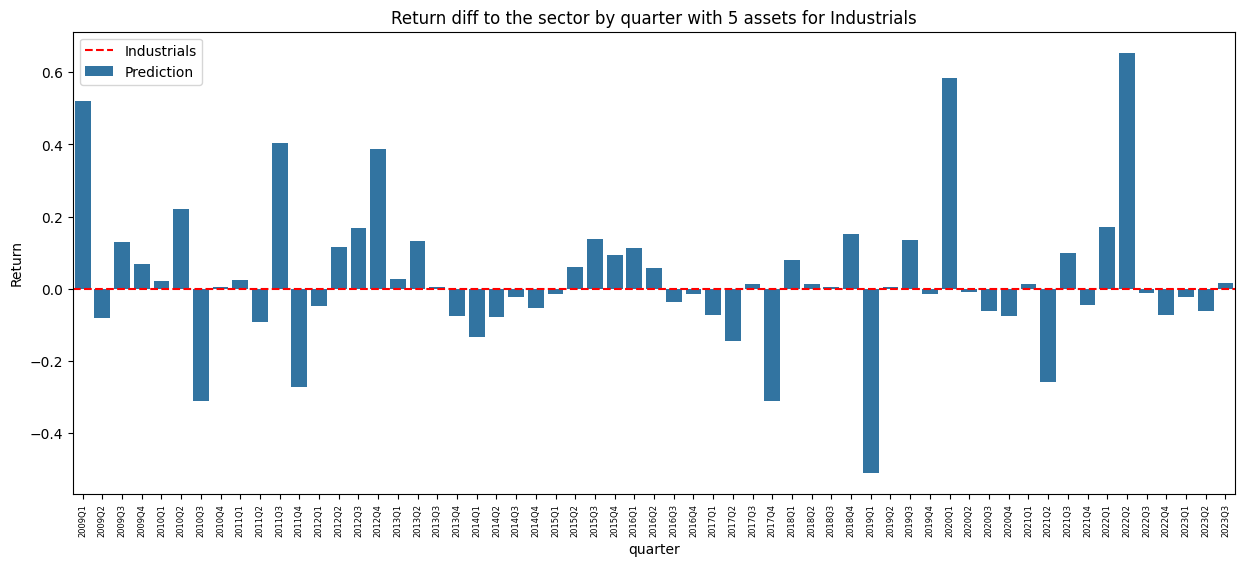

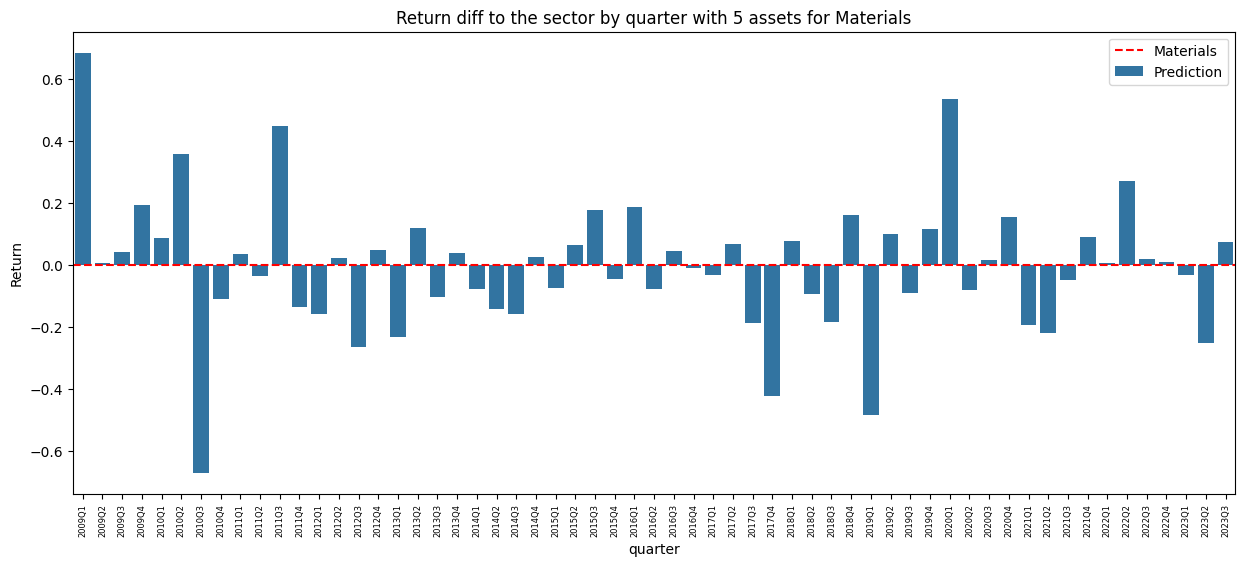

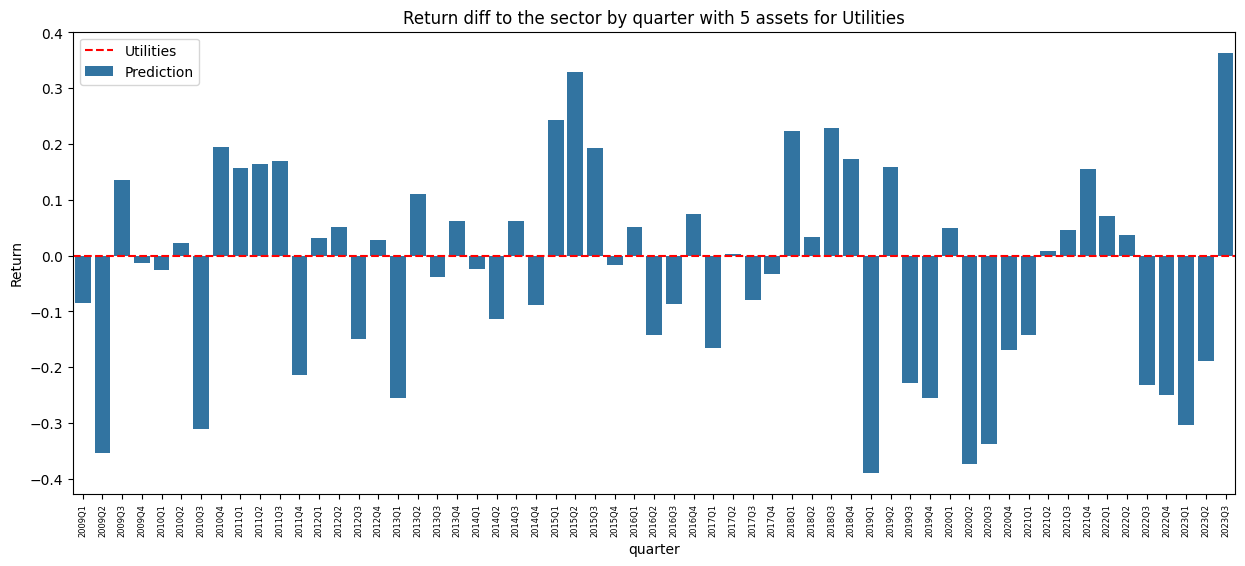

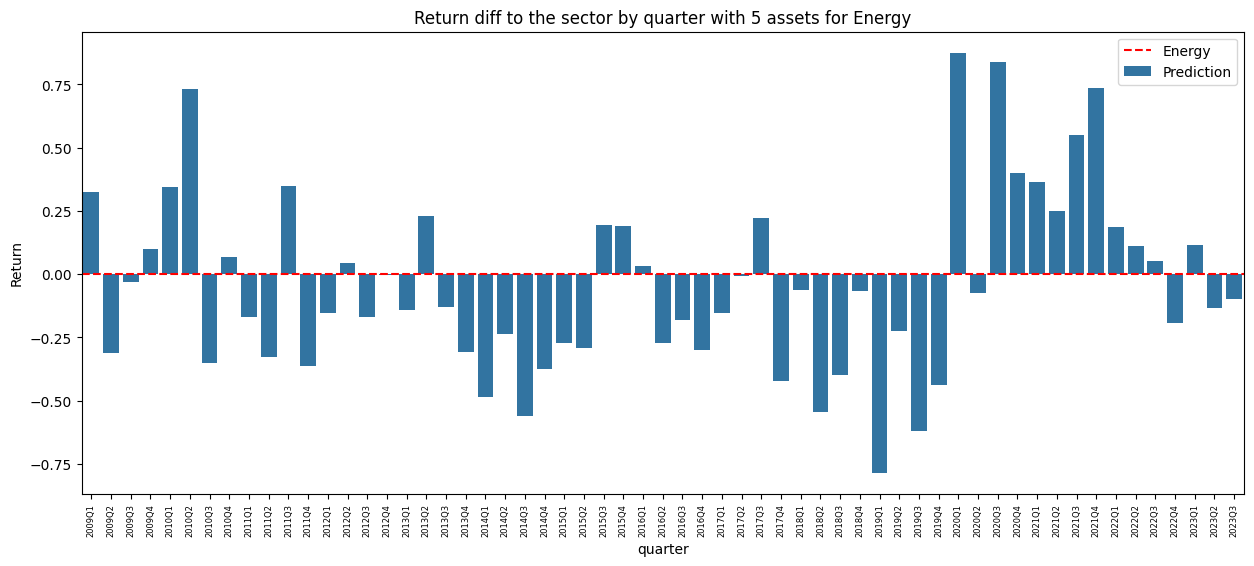

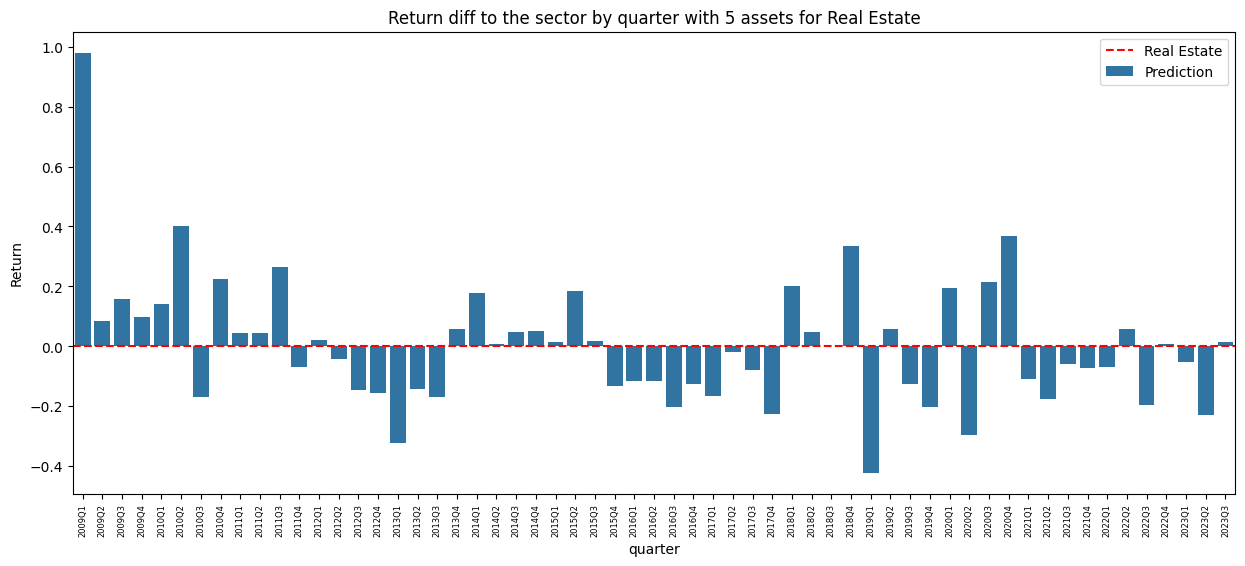

In [182]:
for sector in sector_returns['sector'].unique():
    df_sector = sector_returns[sector_returns['sector'] == sector]
    plt.subplots(figsize=(15, 6))
    sns.barplot(data=df_sector, x='quarter', y='prediction_return',label='Prediction')
    plt.axhline(y=0.0, color='r', linestyle='--', label=sector)
    plt.title(f'Return diff to the sector by quarter with {n_assets} assets for {sector}')
    plt.ylabel('Return')
    plt.xticks(rotation=90, fontsize=6)
    plt.legend()
    plt.show()

### Performance with 20 assets

In [183]:
n_assets = 20
sp500['date'] = sp500['date'].astype(str)
df_returns_quarters = calculate_returns(n_assets=n_assets,
                                        column='1year_price_variation').merge(sp500,
                                                                              left_on='quarter', 
                                                                              right_on='date', how='left').drop(columns='date')

In [184]:
(df_returns_quarters['prediction_return'] > df_returns_quarters['1year_sp500_return']).mean()

0.4576271186440678

In [185]:
df_returns_quarters['prediction_return'].mean()

0.15158401233048271

In [186]:
df_returns_quarters['baseline_return'].mean()

0.15697153159535443

In [187]:
df_returns_quarters['1year_sp500_return'].mean()

0.1525483773289356

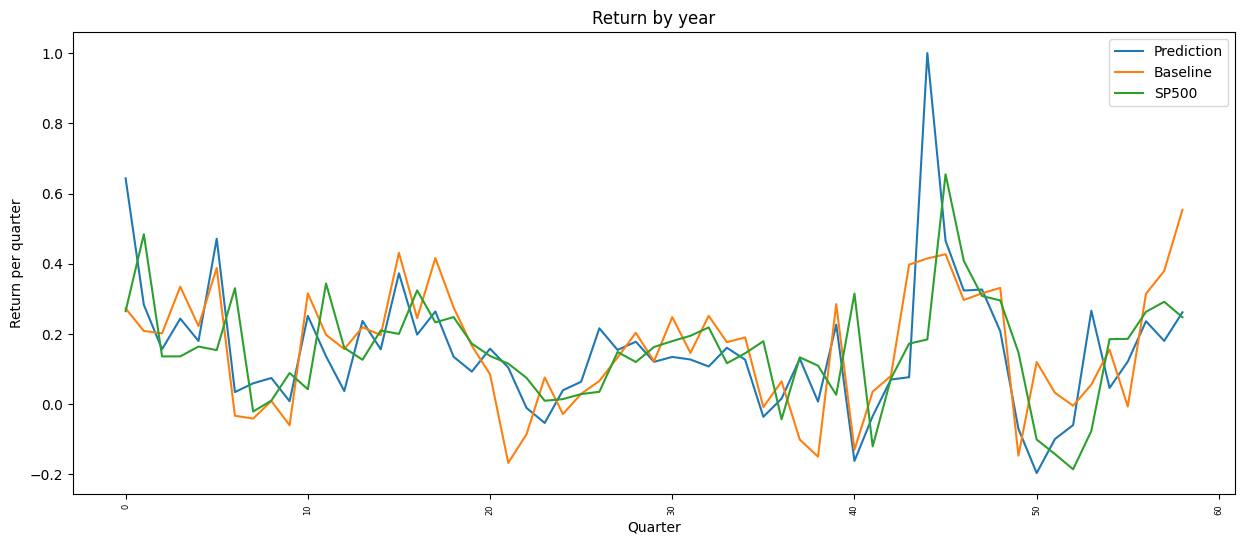

In [188]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df_returns_quarters, x=df_returns_quarters.index, y='prediction_return',label='Prediction')
sns.lineplot(data=df_returns_quarters, x=df_returns_quarters.index, y='baseline_return',label='Baseline')
sns.lineplot(data=df_returns_quarters, x=df_returns_quarters.index, y='1year_sp500_return',label='SP500')
plt.title('Return by year')
plt.xticks(rotation=90, fontsize=6)
plt.xlabel('Quarter')
plt.ylabel('Return per quarter')
plt.show()

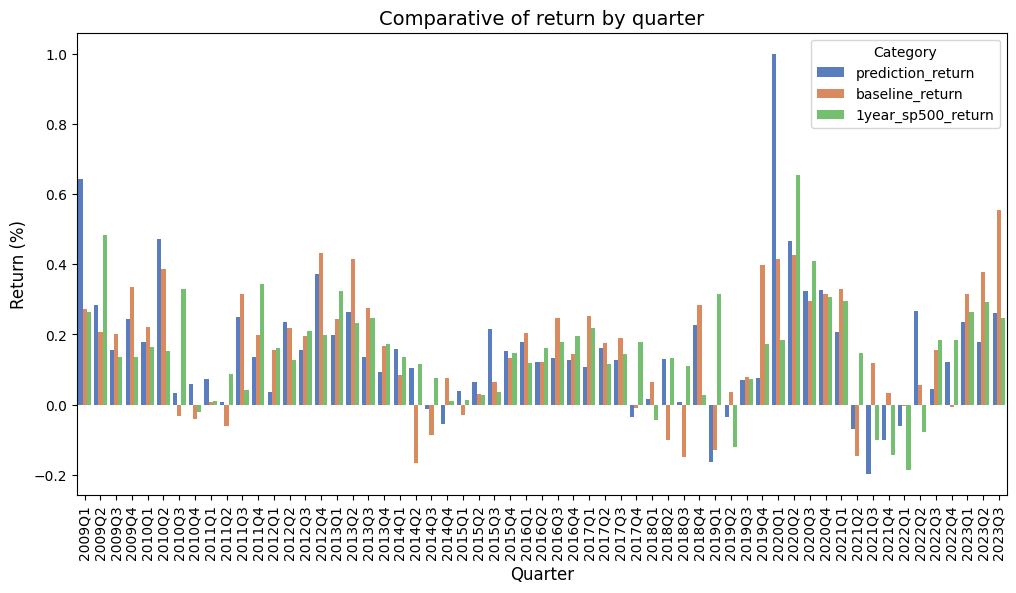

In [191]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


df_melted = df_returns_quarters.melt(id_vars=['quarter'], 
                                     value_vars=['prediction_return', 'baseline_return', '1year_sp500_return'],
                                     var_name='Category', 
                                     value_name='Return')

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x='quarter', y='Return', hue='Category', palette='muted')

plt.title('Comparative of return by quarter', fontsize=14)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Return (%)', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.show()


In [192]:
acumulative_year = acumulative_year_earnings(df_returns_quarters)

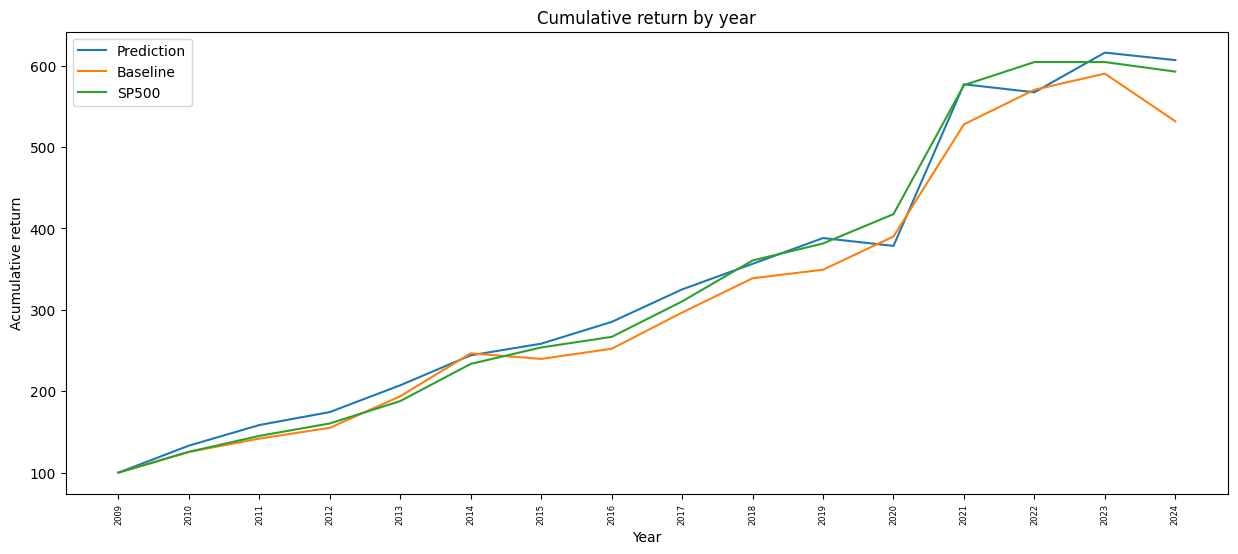

In [193]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=acumulative_year, x=acumulative_year.index, y='cumulative_return_prediction_return',label='Prediction')
sns.lineplot(data=acumulative_year, x=acumulative_year.index, y='cumulative_return_baseline_return',label='Baseline')
sns.lineplot(data=acumulative_year, x=acumulative_year.index, y='cumulative_return_1year_sp500_return',label='SP500')
plt.title('Cumulative return by year')
plt.xticks(rotation=90, fontsize=6)
plt.xlabel('Year')
plt.ylabel('Acumulative return')
plt.show()

In [194]:
acumulative_year.iloc[-1]

cumulative_return_prediction_return     606.766827
cumulative_return_baseline_return       531.605529
cumulative_return_1year_sp500_return    592.642963
Name: 2024, dtype: float64

In [195]:
### CAGR
cagr = lambda x: (x.iloc[-1] / x.iloc[0]) ** (1 / len(x)) - 1
cagr(acumulative_year)*100

cumulative_return_prediction_return     11.928031
cumulative_return_baseline_return       11.006739
cumulative_return_1year_sp500_return    11.763391
dtype: float64

In [196]:
(acumulative_year['cumulative_return_prediction_return'] > acumulative_year['cumulative_return_1year_sp500_return']).mean()

0.75

In [197]:
(acumulative_year['cumulative_return_baseline_return'] > acumulative_year['cumulative_return_1year_sp500_return']).mean()

0.125

### Performance with 10 assets

In [198]:
n_assets = 10
sp500['date'] = sp500['date'].astype(str)
df_returns_quarters = calculate_returns(n_assets=n_assets,
                                        column='1year_price_variation').merge(sp500,
                                                                              left_on='quarter', 
                                                                              right_on='date', how='left').drop(columns='date')


In [199]:
(df_returns_quarters['prediction_return'] > df_returns_quarters['1year_sp500_return']).mean()

0.4576271186440678

In [200]:
df_returns_quarters['prediction_return'].mean()

0.1635182141133435

In [201]:
df_returns_quarters['baseline_return'].mean()

0.1757059811093407

In [202]:
df_returns_quarters['1year_sp500_return'].mean()

0.1525483773289356

In [203]:
acumulative_year = acumulative_year_earnings(df_returns_quarters)

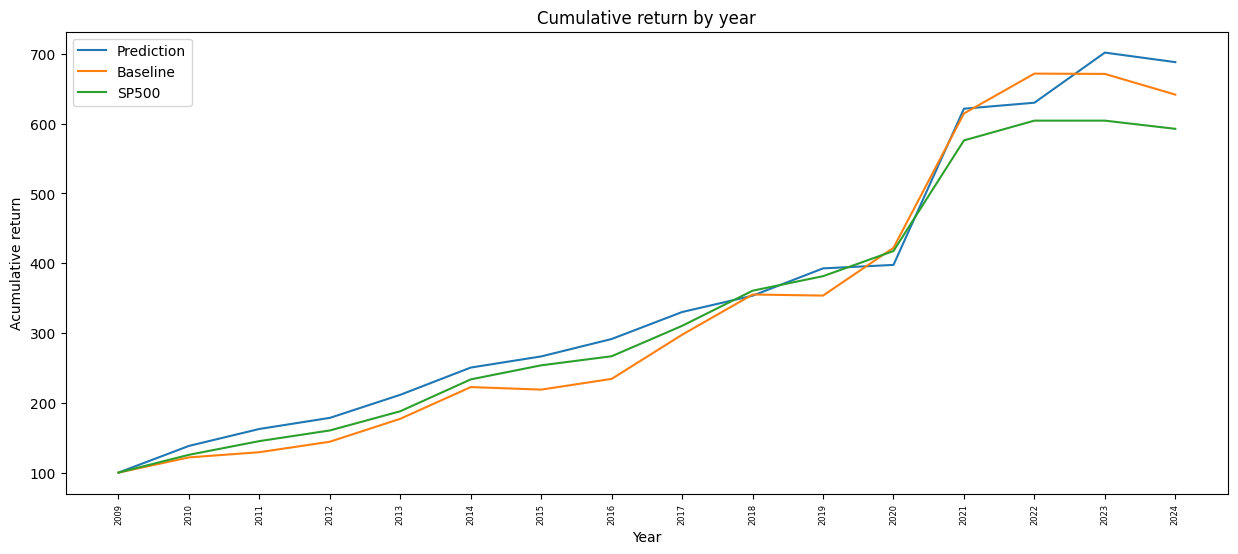

In [204]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=acumulative_year, x=acumulative_year.index, y='cumulative_return_prediction_return',label='Prediction')
sns.lineplot(data=acumulative_year, x=acumulative_year.index, y='cumulative_return_baseline_return',label='Baseline')
sns.lineplot(data=acumulative_year, x=acumulative_year.index, y='cumulative_return_1year_sp500_return',label='SP500')
plt.title('Cumulative return by year')
plt.xticks(rotation=90, fontsize=6)
plt.xlabel('Year')
plt.ylabel('Acumulative return')
plt.show()

In [205]:
acumulative_year.iloc[-1]

cumulative_return_prediction_return     688.204850
cumulative_return_baseline_return       641.672696
cumulative_return_1year_sp500_return    592.642963
Name: 2024, dtype: float64

In [206]:
### CAGR
cagr = lambda x: (x.iloc[-1] / x.iloc[0]) ** (1 / len(x)) - 1
cagr(acumulative_year)*100

cumulative_return_prediction_return     12.812535
cumulative_return_baseline_return       12.320001
cumulative_return_1year_sp500_return    11.763391
dtype: float64

In [207]:
(acumulative_year['cumulative_return_prediction_return'] > acumulative_year['cumulative_return_1year_sp500_return']).mean()

0.8125

In [208]:
(acumulative_year['cumulative_return_baseline_return'] > acumulative_year['cumulative_return_1year_sp500_return']).mean()

0.3125

### Performance with 5 assets

In [209]:
n_assets = 5
sp500['date'] = sp500['date'].astype(str)
df_returns_quarters = calculate_returns(n_assets=n_assets,
                                        column='1year_price_variation').merge(sp500,
                                                                              left_on='quarter', 
                                                                              right_on='date', how='left').drop(columns='date')


In [210]:
(df_returns_quarters['prediction_return'] > df_returns_quarters['1year_sp500_return']).mean()

0.4915254237288136

In [211]:
df_returns_quarters['prediction_return'].mean()

0.1747418881892653

In [212]:
df_returns_quarters['baseline_return'].mean()

0.22120015662961945

In [213]:
df_returns_quarters['1year_sp500_return'].mean()

0.1525483773289356

In [214]:
acumulative_year = acumulative_year_earnings(df_returns_quarters)

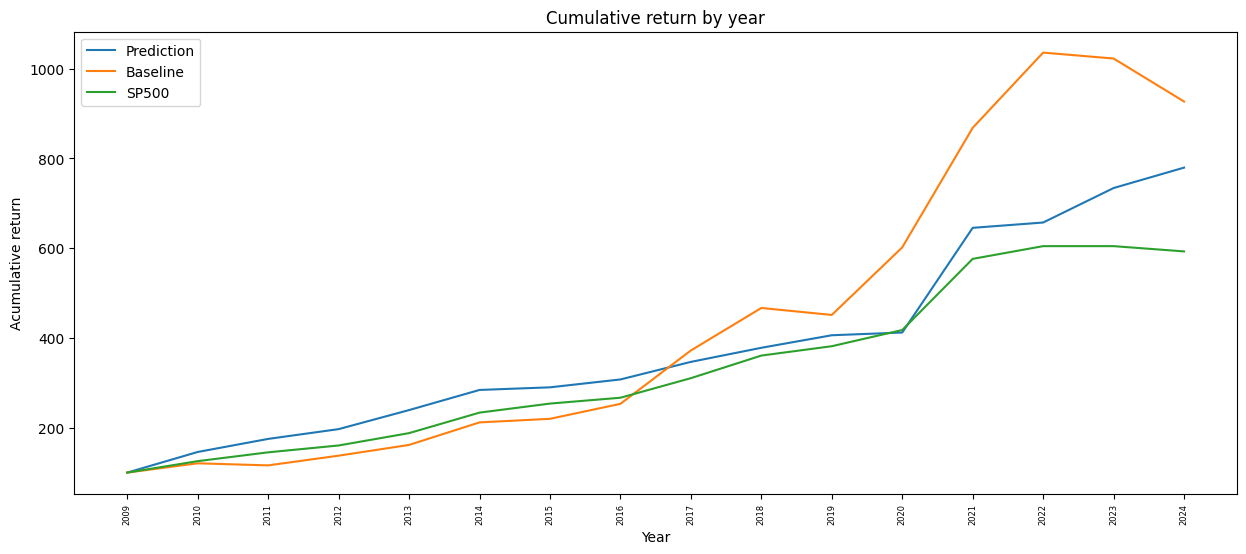

In [215]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=acumulative_year, x=acumulative_year.index, y='cumulative_return_prediction_return',label='Prediction')
sns.lineplot(data=acumulative_year, x=acumulative_year.index, y='cumulative_return_baseline_return',label='Baseline')
sns.lineplot(data=acumulative_year, x=acumulative_year.index, y='cumulative_return_1year_sp500_return',label='SP500')
plt.title('Cumulative return by year')
plt.xticks(rotation=90, fontsize=6)
plt.xlabel('Year')
plt.ylabel('Acumulative return')
plt.show()

In [216]:
acumulative_year.iloc[-1]

cumulative_return_prediction_return     779.249593
cumulative_return_baseline_return       926.437480
cumulative_return_1year_sp500_return    592.642963
Name: 2024, dtype: float64

In [217]:
### CAGR
cagr = lambda x: (x.iloc[-1] / x.iloc[0]) ** (1 / len(x)) - 1
cagr(acumulative_year)*100

cumulative_return_prediction_return     13.691969
cumulative_return_baseline_return       14.928042
cumulative_return_1year_sp500_return    11.763391
dtype: float64

In [218]:
(acumulative_year['cumulative_return_prediction_return'] > acumulative_year['cumulative_return_1year_sp500_return']).mean()

0.875

In [219]:
(acumulative_year['cumulative_return_baseline_return'] > acumulative_year['cumulative_return_1year_sp500_return']).mean()

0.5

### Return depending on the year the porfolio was created

In [220]:
n_assets =  10
df_returns_quarters = calculate_returns(n_assets=n_assets,
                                        column='1year_price_variation').merge(sp500,
                                                                              left_on='quarter', 
                                                                              right_on='date', how='left').drop(columns='date')

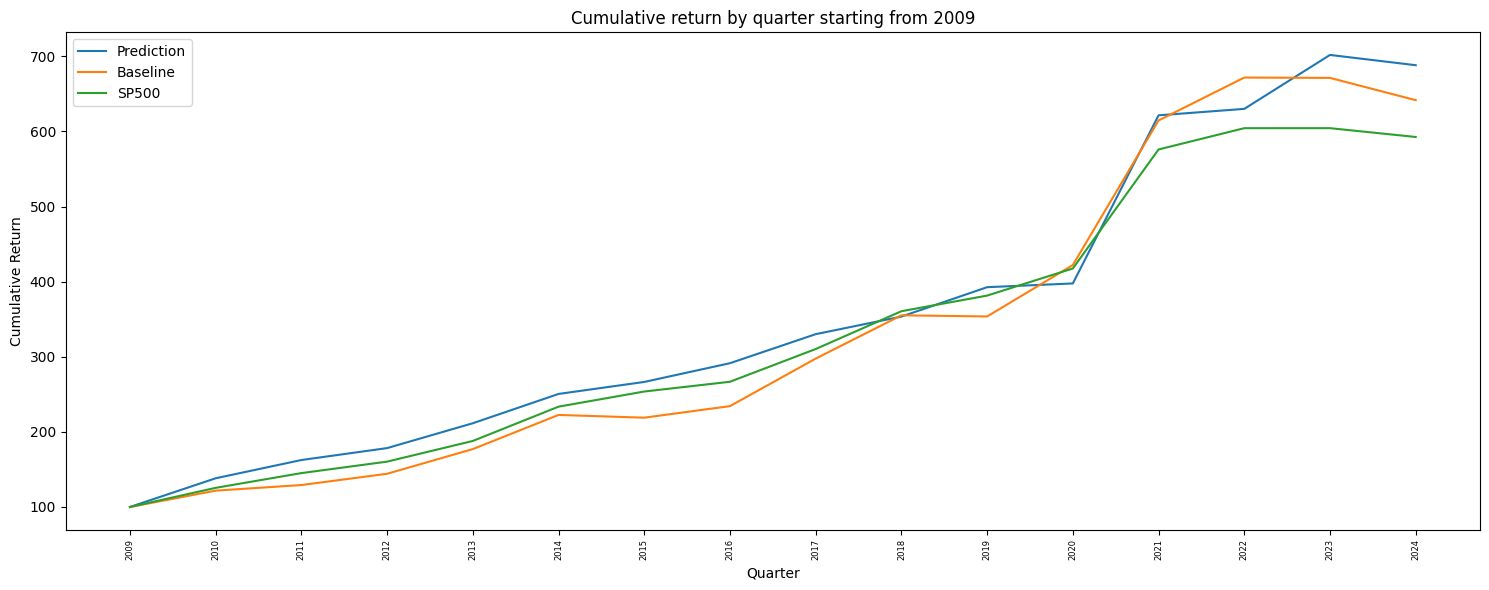

Year: 2009
cumulative_return_prediction_return     12.812535
cumulative_return_baseline_return       12.320001
cumulative_return_1year_sp500_return    11.763391
dtype: float64
Prediction > SP500: 0.8125
Baseline > SP500: 0.3125



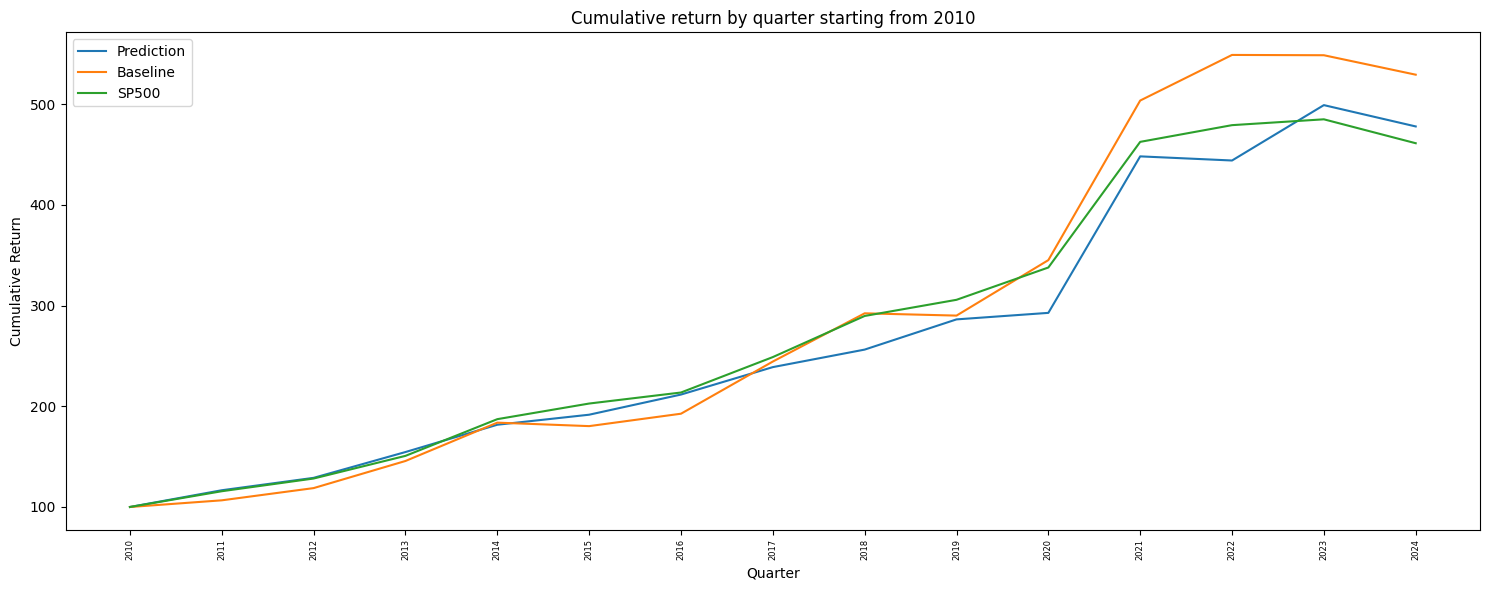

Year: 2010
cumulative_return_prediction_return     10.989461
cumulative_return_baseline_return       11.747783
cumulative_return_1year_sp500_return    10.727079
dtype: float64
Prediction > SP500: 0.3333333333333333
Baseline > SP500: 0.4



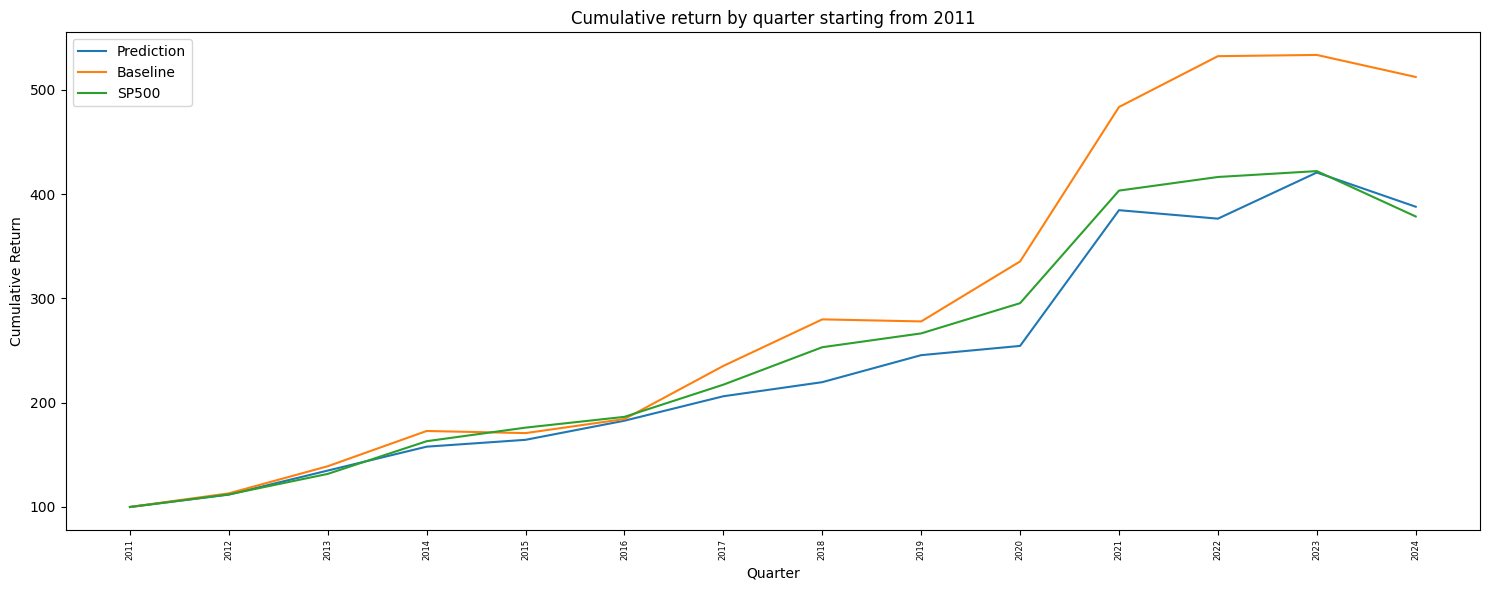

Year: 2011
cumulative_return_prediction_return     10.167478
cumulative_return_baseline_return       12.378543
cumulative_return_1year_sp500_return     9.975597
dtype: float64
Prediction > SP500: 0.14285714285714285
Baseline > SP500: 0.7857142857142857



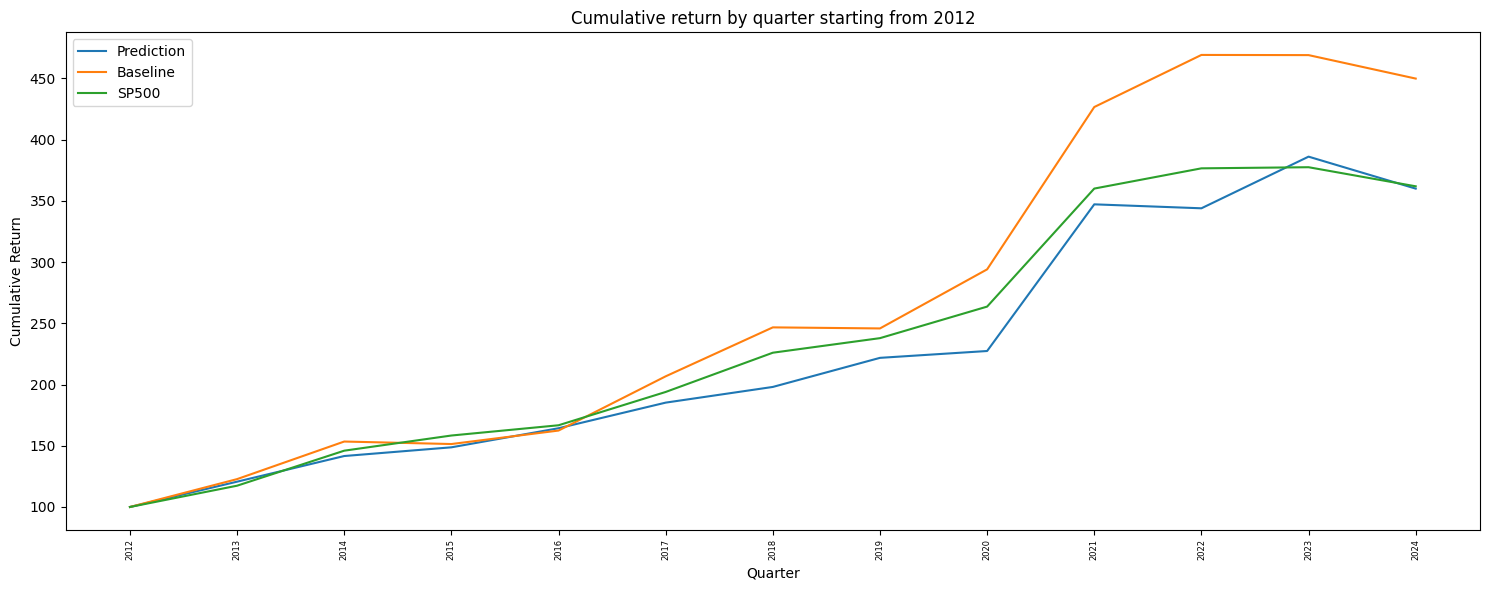

Year: 2012
cumulative_return_prediction_return     10.354663
cumulative_return_baseline_return       12.262733
cumulative_return_1year_sp500_return    10.399114
dtype: float64
Prediction > SP500: 0.15384615384615385
Baseline > SP500: 0.7692307692307693



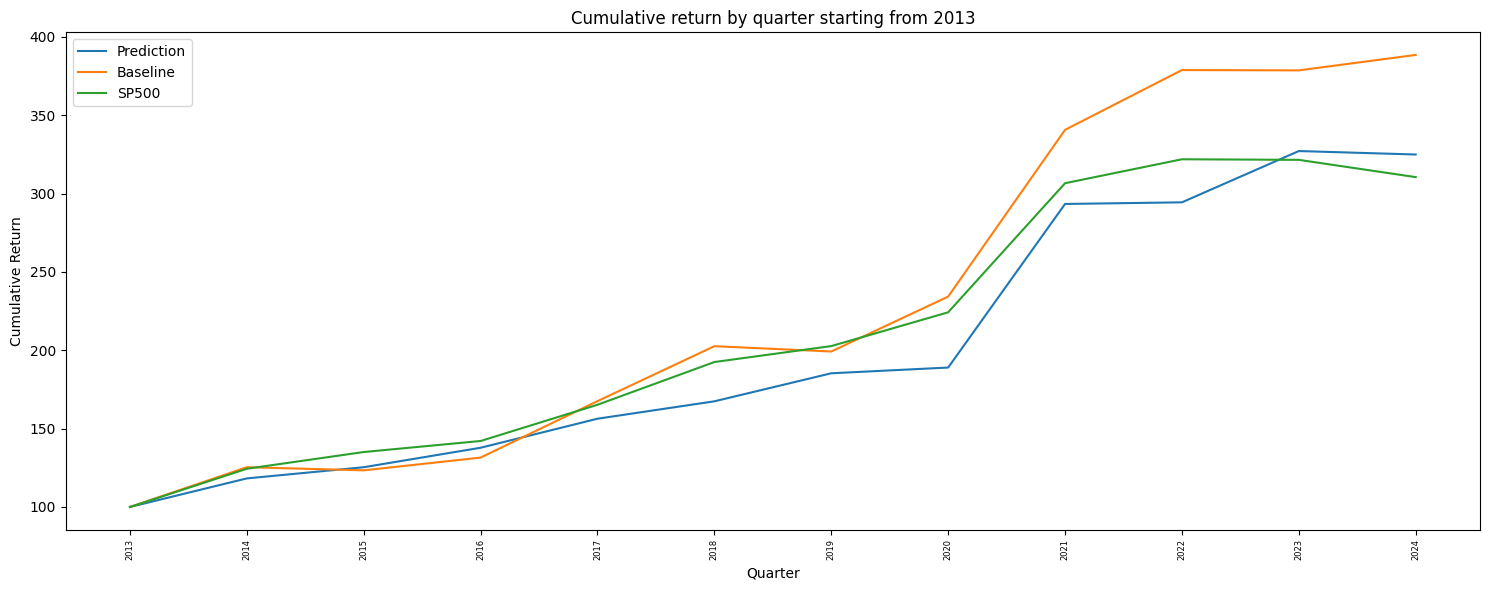

Year: 2013
cumulative_return_prediction_return     10.319498
cumulative_return_baseline_return       11.973680
cumulative_return_1year_sp500_return     9.902606
dtype: float64
Prediction > SP500: 0.16666666666666666
Baseline > SP500: 0.6666666666666666



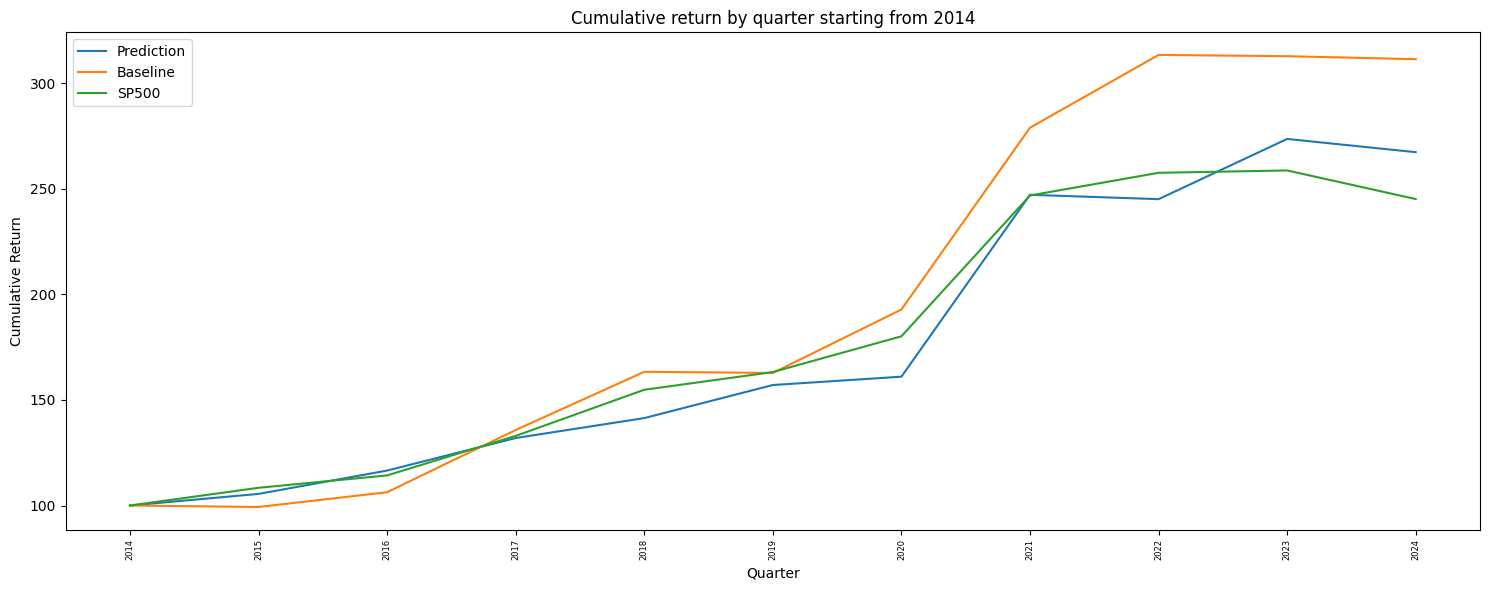

Year: 2014
cumulative_return_prediction_return      9.350706
cumulative_return_baseline_return       10.877043
cumulative_return_1year_sp500_return     8.492446
dtype: float64
Prediction > SP500: 0.36363636363636365
Baseline > SP500: 0.6363636363636364



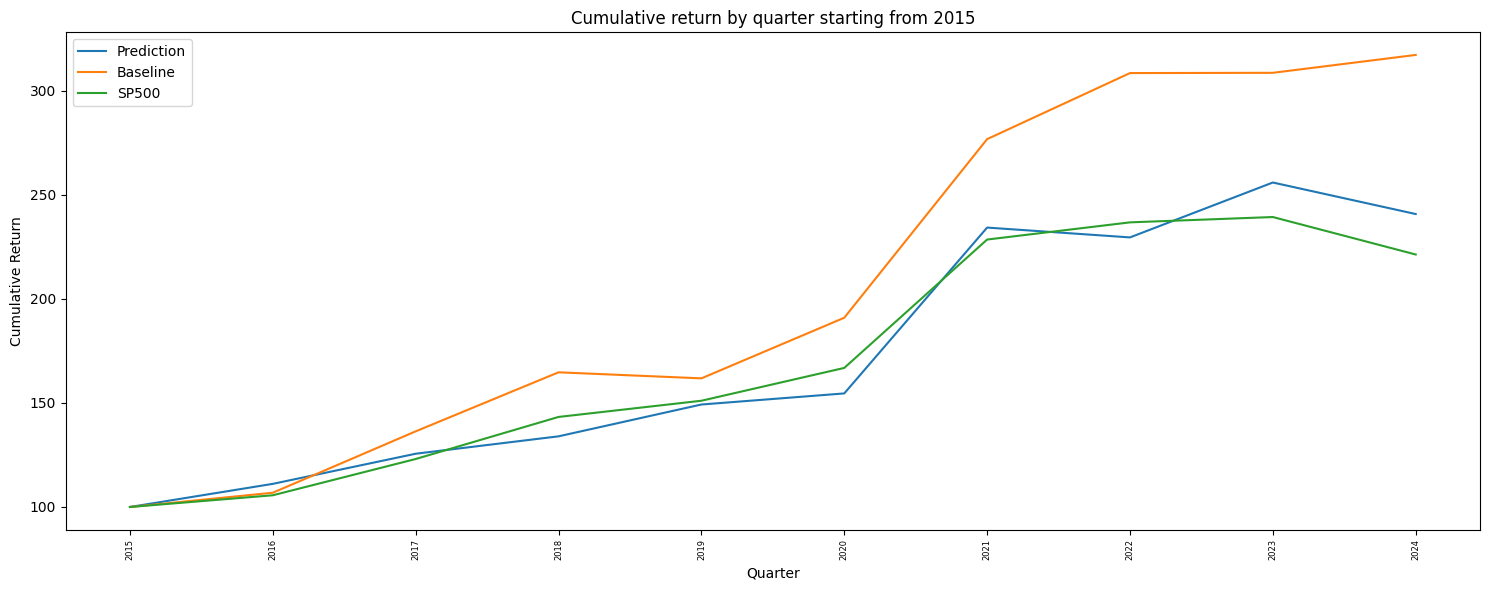

Year: 2015
cumulative_return_prediction_return      9.183836
cumulative_return_baseline_return       12.236269
cumulative_return_1year_sp500_return     8.268191
dtype: float64
Prediction > SP500: 0.5
Baseline > SP500: 0.9



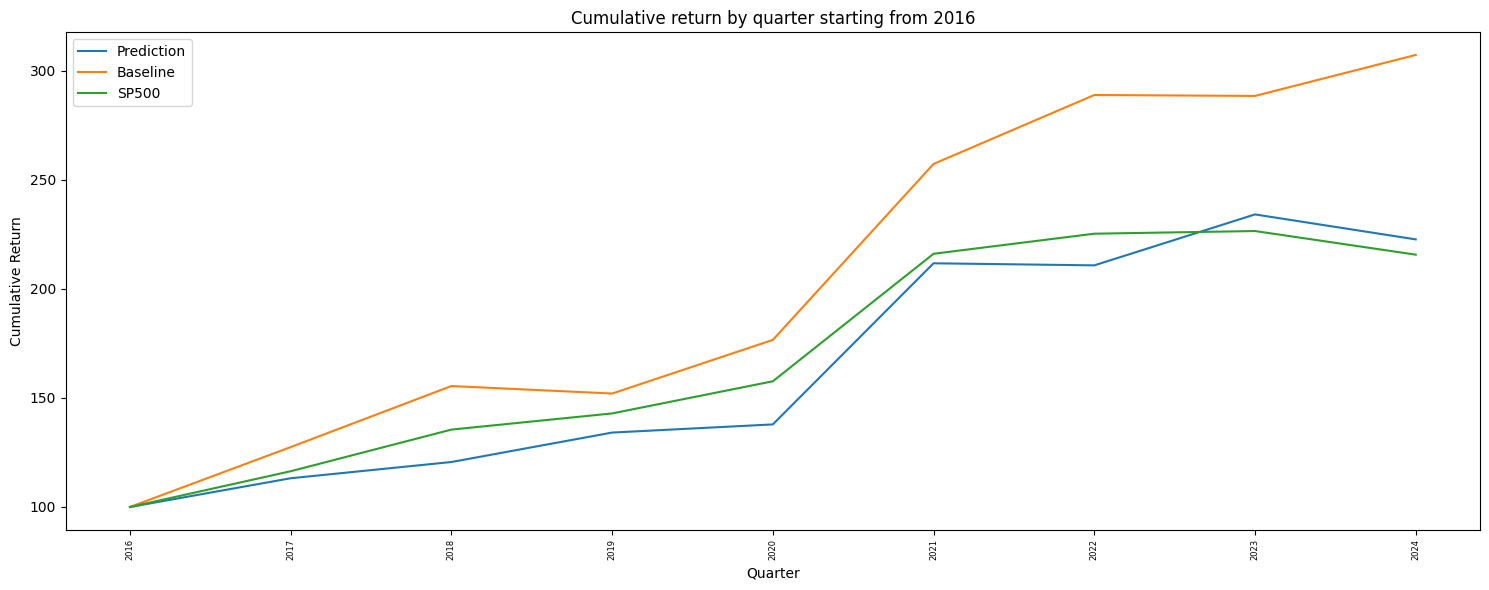

Year: 2016
cumulative_return_prediction_return      9.304479
cumulative_return_baseline_return       13.284727
cumulative_return_1year_sp500_return     8.917263
dtype: float64
Prediction > SP500: 0.2222222222222222
Baseline > SP500: 0.8888888888888888



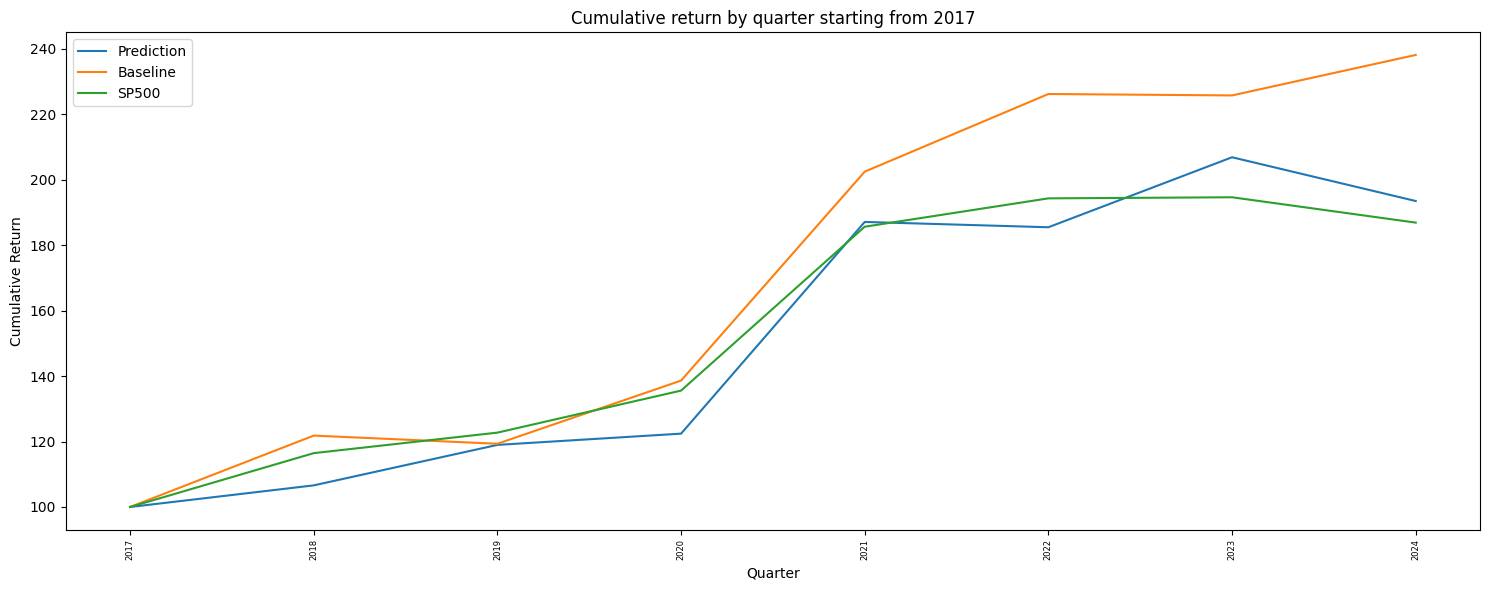

Year: 2017
cumulative_return_prediction_return      8.598475
cumulative_return_baseline_return       11.452860
cumulative_return_1year_sp500_return     8.128792
dtype: float64
Prediction > SP500: 0.375
Baseline > SP500: 0.75



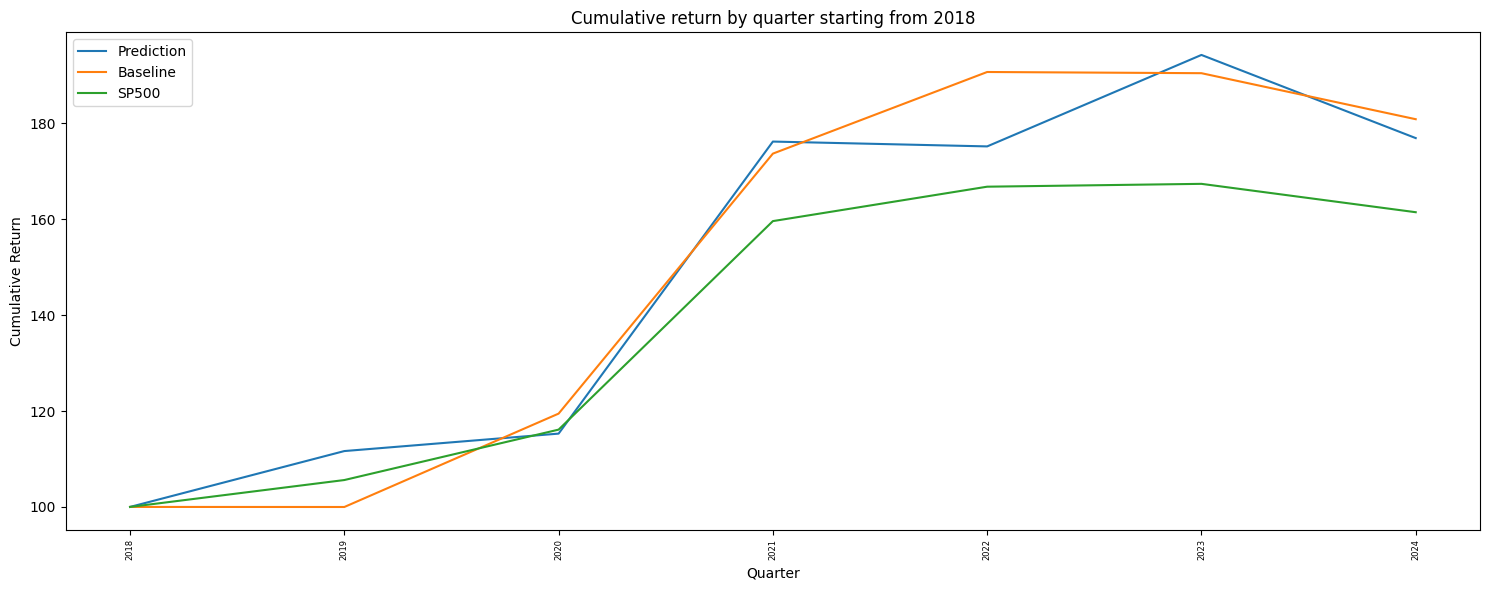

Year: 2018
cumulative_return_prediction_return     8.492237
cumulative_return_baseline_return       8.834094
cumulative_return_1year_sp500_return    7.084379
dtype: float64
Prediction > SP500: 0.7142857142857143
Baseline > SP500: 0.7142857142857143



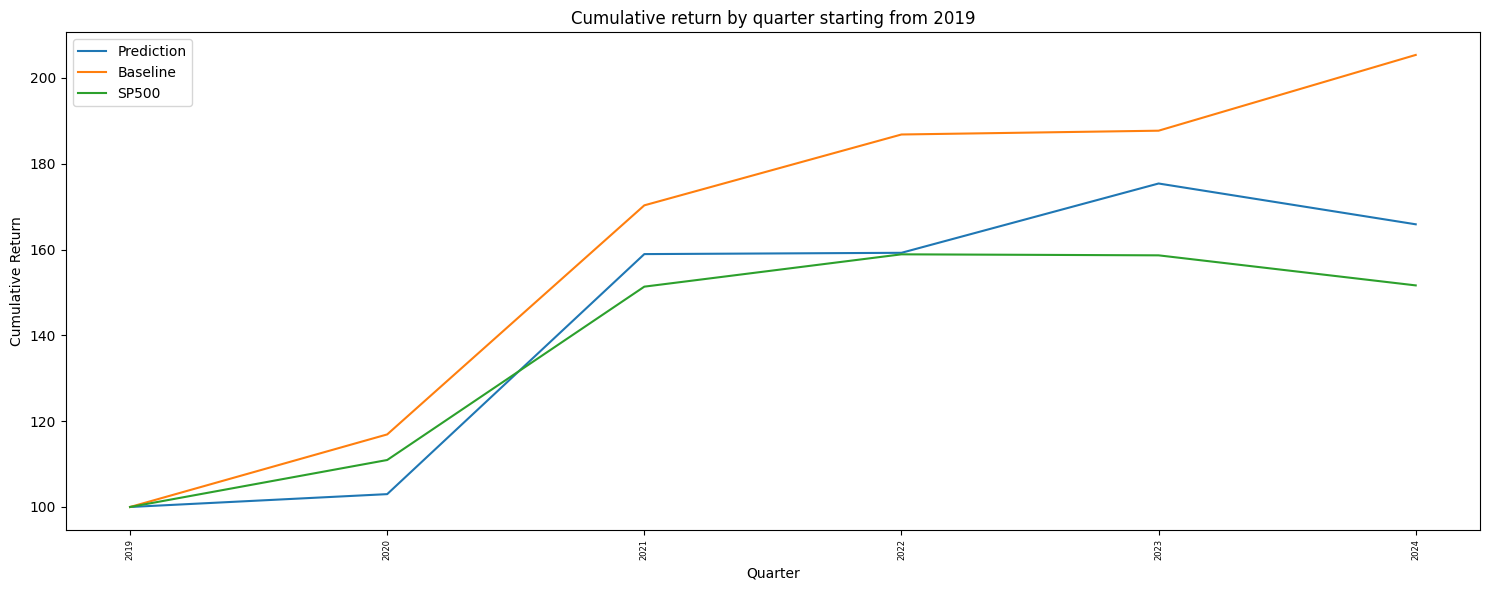

Year: 2019
cumulative_return_prediction_return      8.802483
cumulative_return_baseline_return       12.743294
cumulative_return_1year_sp500_return     7.187042
dtype: float64
Prediction > SP500: 0.6666666666666666
Baseline > SP500: 0.8333333333333334



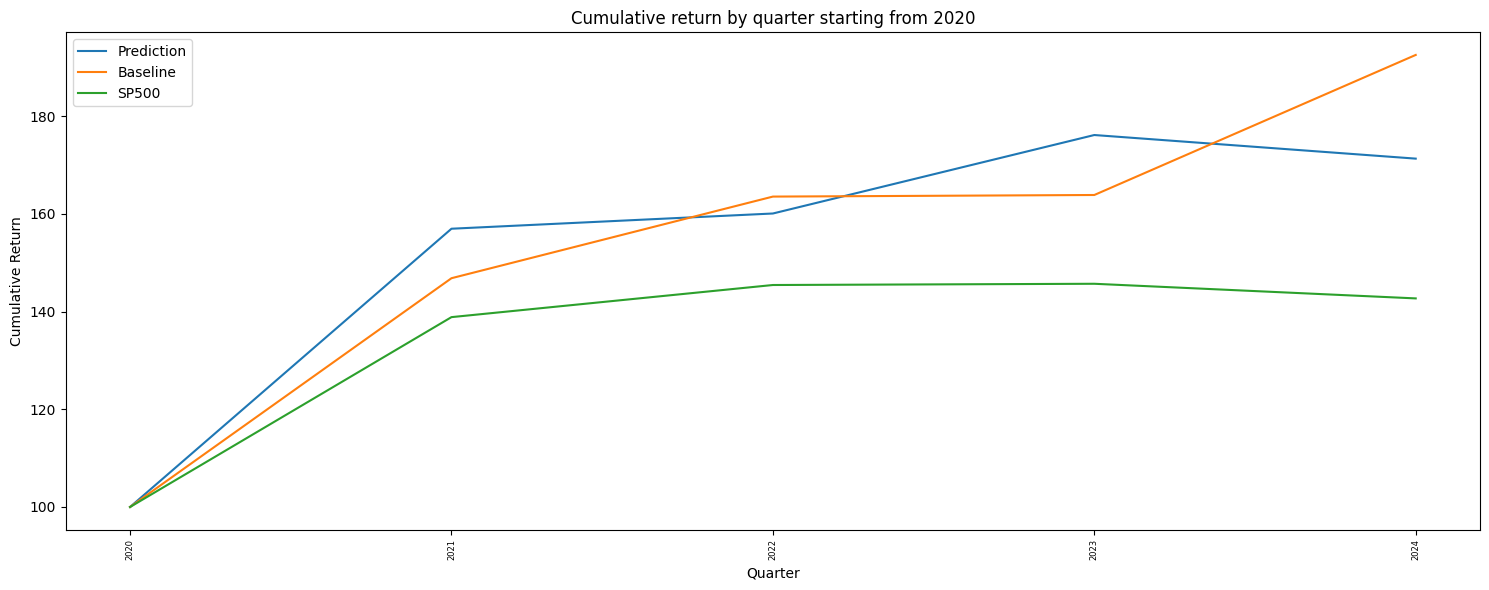

Year: 2020
cumulative_return_prediction_return     11.370688
cumulative_return_baseline_return       14.003766
cumulative_return_1year_sp500_return     7.372779
dtype: float64
Prediction > SP500: 0.8
Baseline > SP500: 0.8



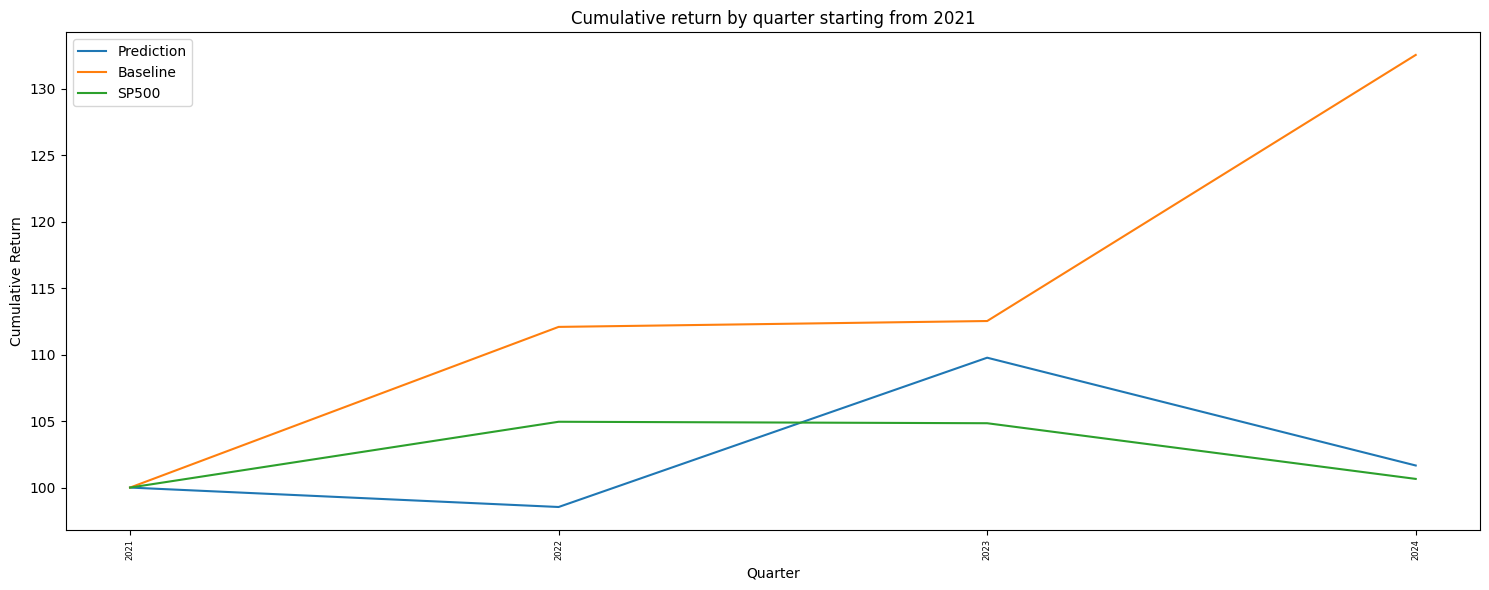

Year: 2021
cumulative_return_prediction_return     0.412434
cumulative_return_baseline_return       7.295425
cumulative_return_1year_sp500_return    0.162519
dtype: float64
Prediction > SP500: 0.5
Baseline > SP500: 0.75



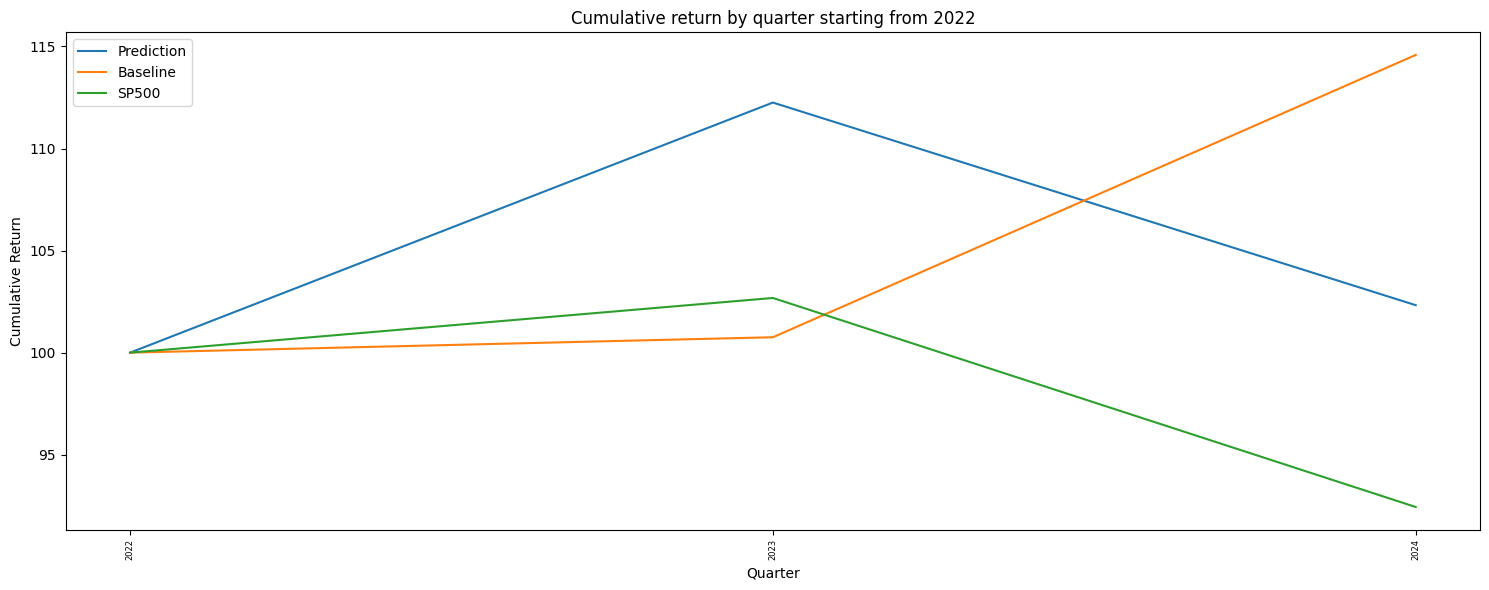

Year: 2022
cumulative_return_prediction_return     0.769283
cumulative_return_baseline_return       4.642198
cumulative_return_1year_sp500_return   -2.586366
dtype: float64
Prediction > SP500: 0.6666666666666666
Baseline > SP500: 0.3333333333333333



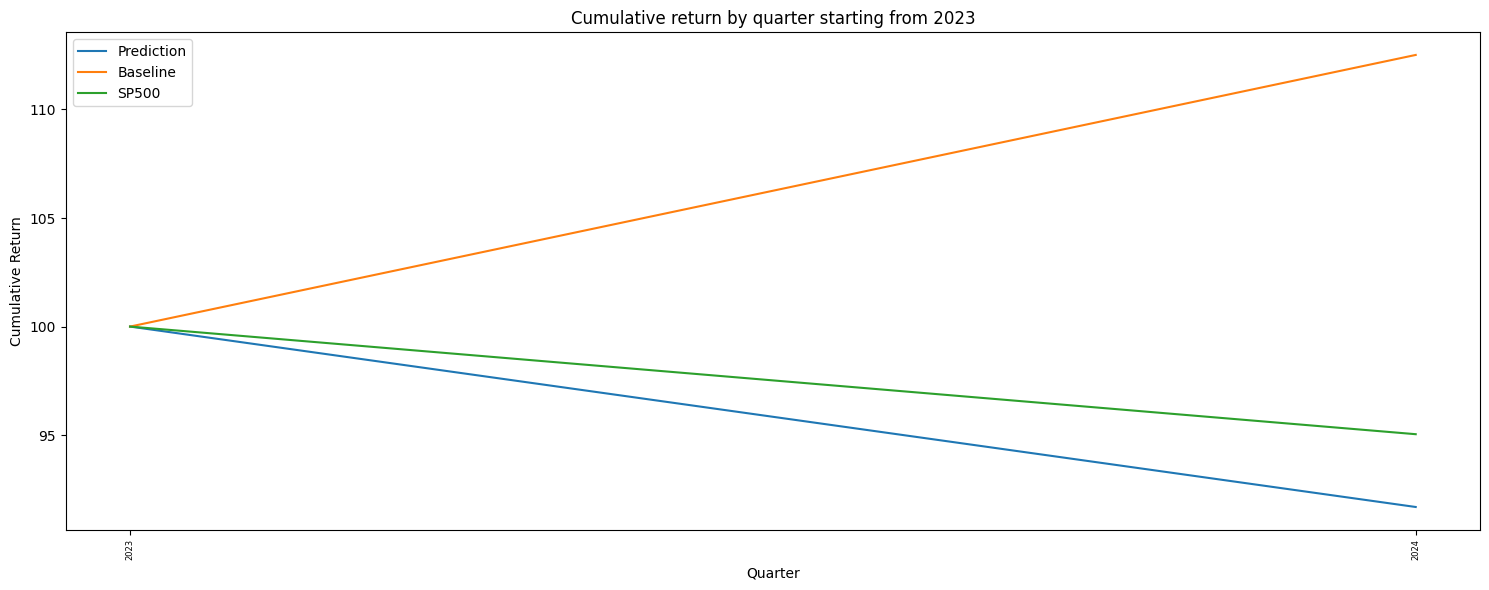

Year: 2023
cumulative_return_prediction_return    -4.245070
cumulative_return_baseline_return       6.071261
cumulative_return_1year_sp500_return   -2.510148
dtype: float64
Prediction > SP500: 0.0
Baseline > SP500: 0.5



In [221]:
unique_years = df_returns_quarters['quarter'].str[:4].unique()

for i, year in enumerate(unique_years):
    # Filtrar el DataFrame eliminando los años anteriores al año actual en la iteración
    remaining_years = unique_years[i:]  # Toma los años desde la posición actual hasta el final
    filtered_df = df_returns_quarters[df_returns_quarters['quarter'].str[:4].isin(remaining_years)]
    
    # Calcular los retornos acumulativos con el DataFrame filtrado
    acumulative_year = acumulative_year_earnings(filtered_df)
    
    # Crear el gráfico
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=acumulative_year, x=acumulative_year.index, y='cumulative_return_prediction_return', label='Prediction')
    sns.lineplot(data=acumulative_year, x=acumulative_year.index, y='cumulative_return_baseline_return', label='Baseline')
    sns.lineplot(data=acumulative_year, x=acumulative_year.index, y='cumulative_return_1year_sp500_return', label='SP500')
    
    # Personalización del gráfico
    plt.title(f'Cumulative return by quarter starting from {year}')
    plt.xticks(rotation=90, fontsize=6)
    plt.xlabel('Quarter')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"Year: {year}")
    print(cagr(acumulative_year)*100)
    print(f"Prediction > SP500: {(acumulative_year['cumulative_return_prediction_return'] > acumulative_year['cumulative_return_1year_sp500_return']).mean()}")
    print(f"Baseline > SP500: {(acumulative_year['cumulative_return_baseline_return'] > acumulative_year['cumulative_return_1year_sp500_return']).mean()}")
    print("")
    

### Insights from the analysis
As we can see, in order to analyze the consistency of our model, it may be better to check the independent returns of each quarter, rather than the cumulative return. That's because the cumulative return may be influenced by the performance of the model in the first quarter, this can be seen on the 2009, where the model seems to have a great consistency, due to the performance of the first year, but in the following years, the performance is similar to SP500. The opposite can be seen on the following years, where the model seems to have a bad consistency, but in the end,the model outperformed the SP500. 

### Performance with 5 assets per sector

In [222]:
n_assets = 5
sector_returns = calculate_returns(sector_df=True,n_assets=n_assets,column='1year_price_variation')

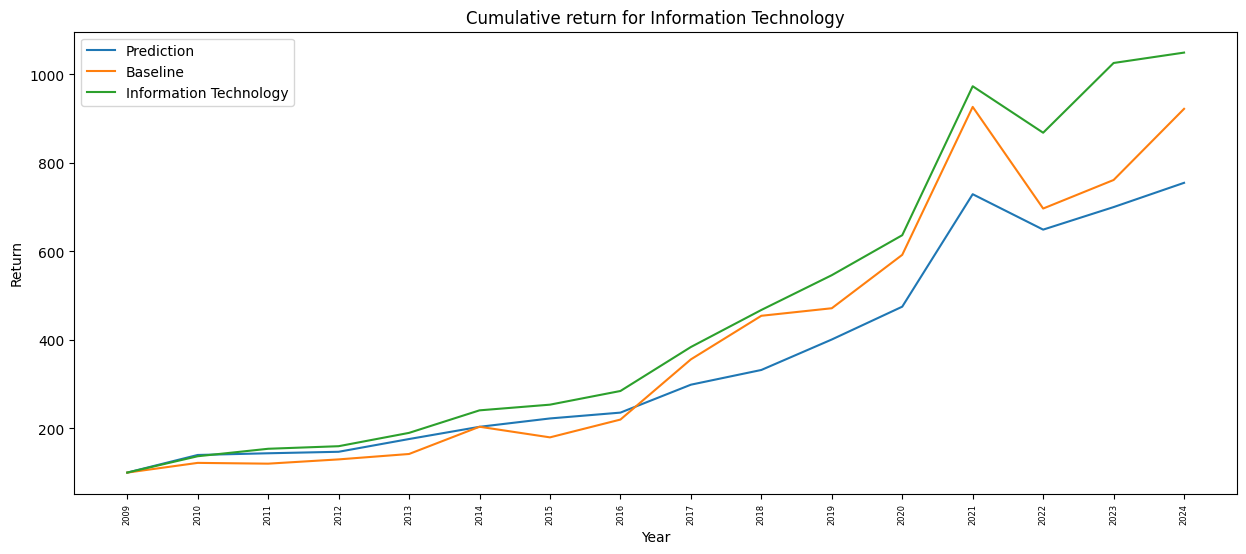

Anualized return for Information Technology
cumulative_return_prediction_return    13.466433
cumulative_return_baseline_return      14.894145
cumulative_return_sector_return        15.825332
dtype: float64


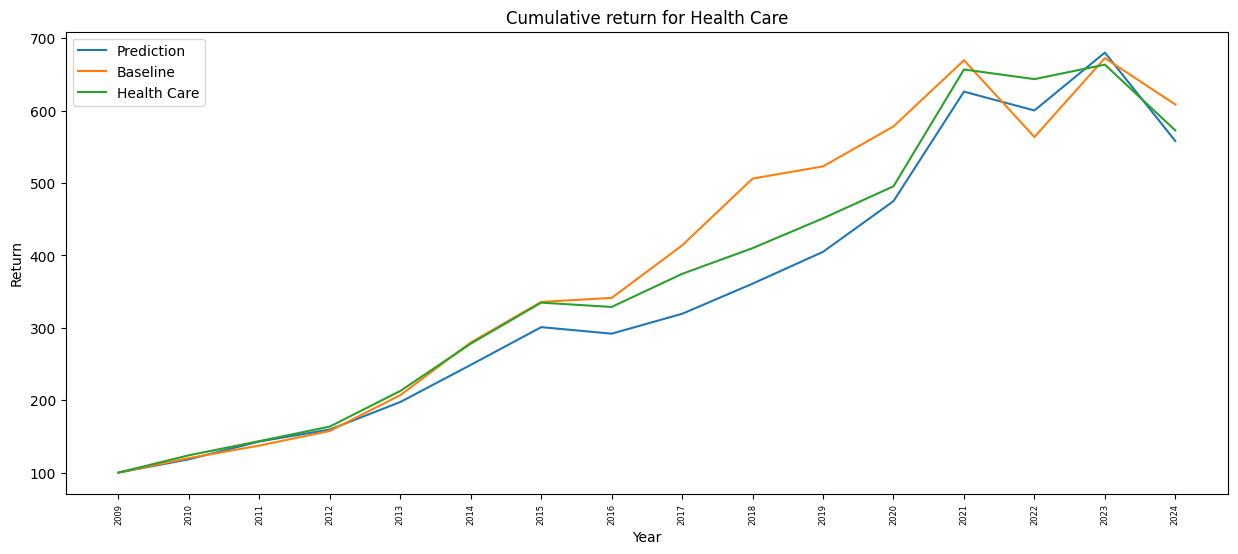

Anualized return for Health Care
cumulative_return_prediction_return    11.342887
cumulative_return_baseline_return      11.946829
cumulative_return_sector_return        11.523774
dtype: float64


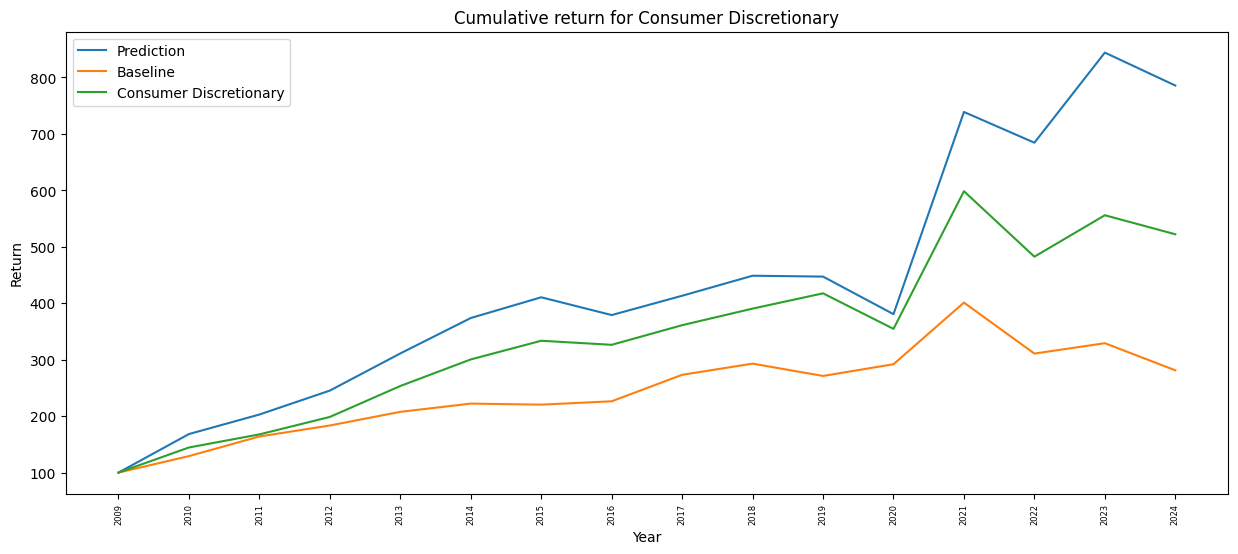

Anualized return for Consumer Discretionary
cumulative_return_prediction_return    13.749081
cumulative_return_baseline_return       6.674209
cumulative_return_sector_return        10.881734
dtype: float64


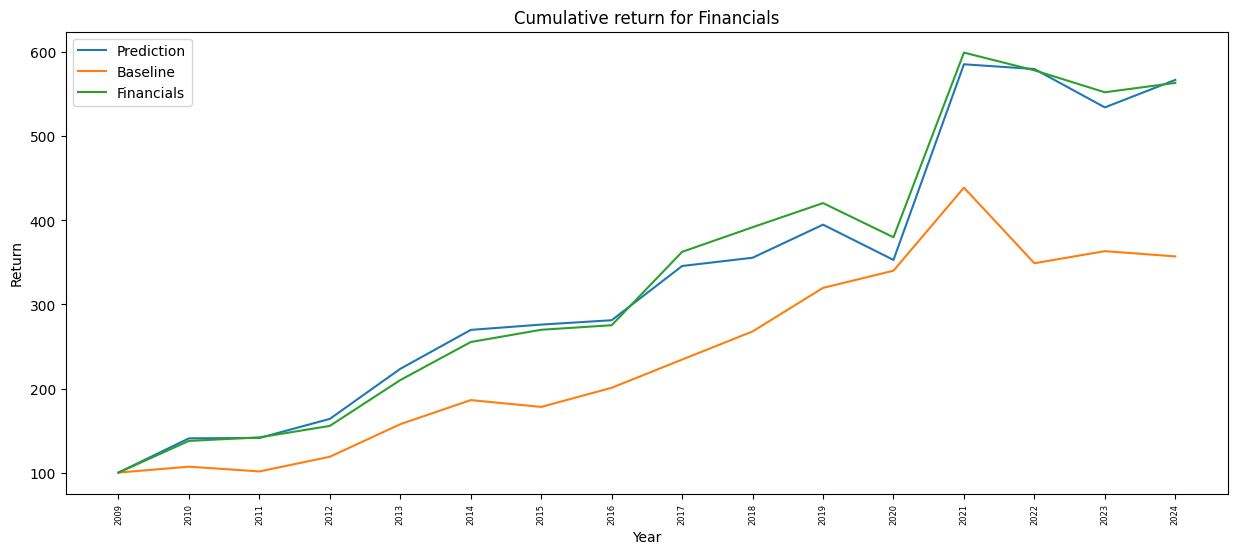

Anualized return for Financials
cumulative_return_prediction_return    11.455026
cumulative_return_baseline_return       8.280418
cumulative_return_sector_return        11.411276
dtype: float64


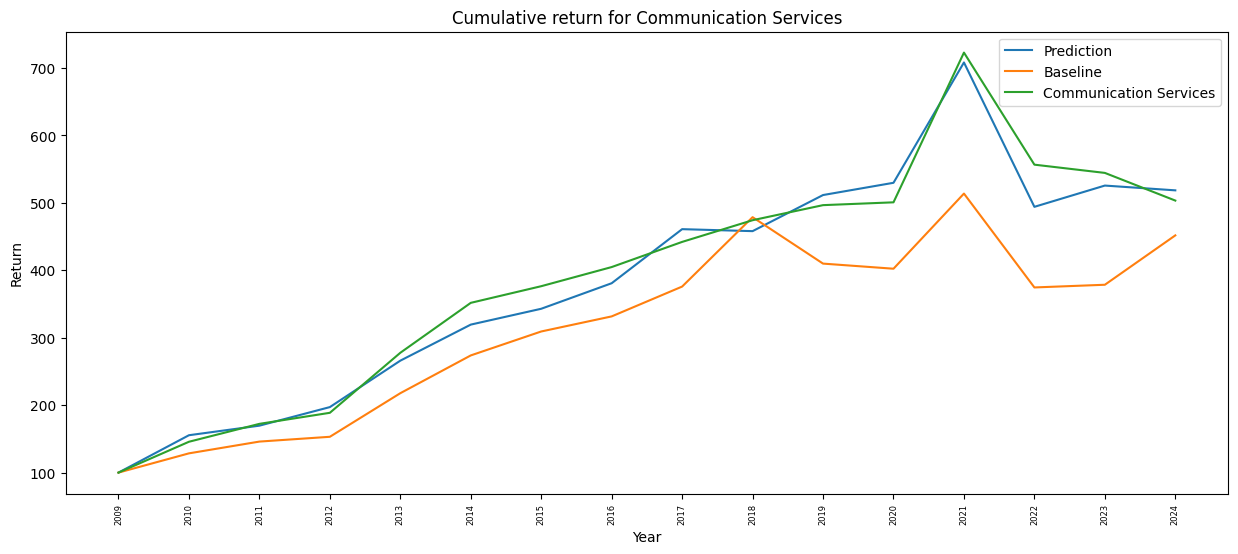

Anualized return for Communication Services
cumulative_return_prediction_return    10.832259
cumulative_return_baseline_return       9.881442
cumulative_return_sector_return        10.626767
dtype: float64


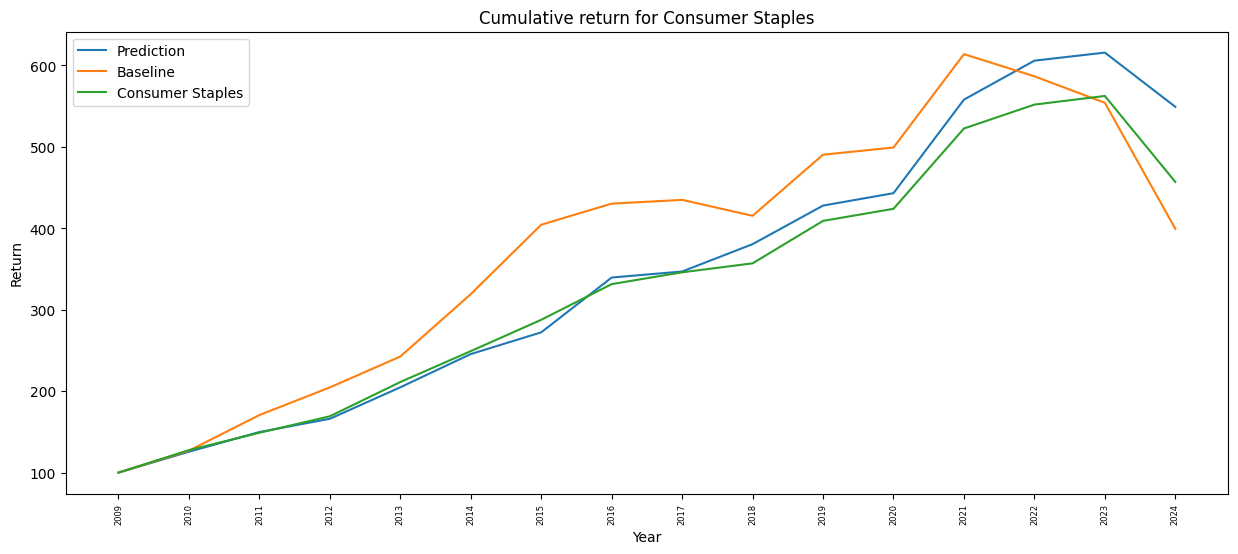

Anualized return for Consumer Staples
cumulative_return_prediction_return    11.233413
cumulative_return_baseline_return       9.041555
cumulative_return_sector_return         9.962847
dtype: float64


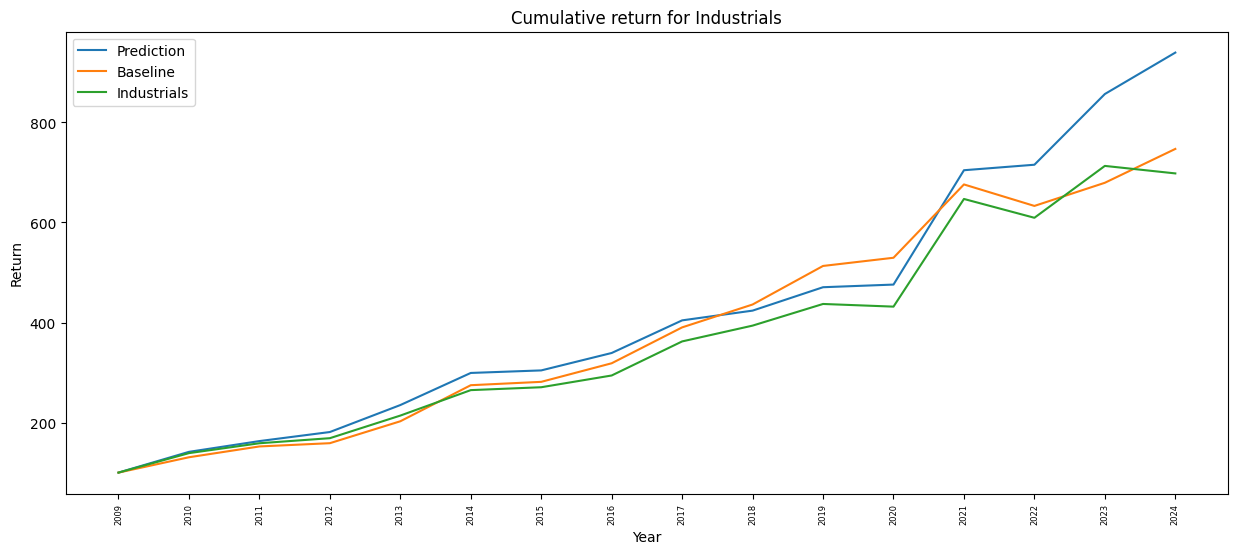

Anualized return for Industrials
cumulative_return_prediction_return    15.028583
cumulative_return_baseline_return      13.391614
cumulative_return_sector_return        12.912353
dtype: float64


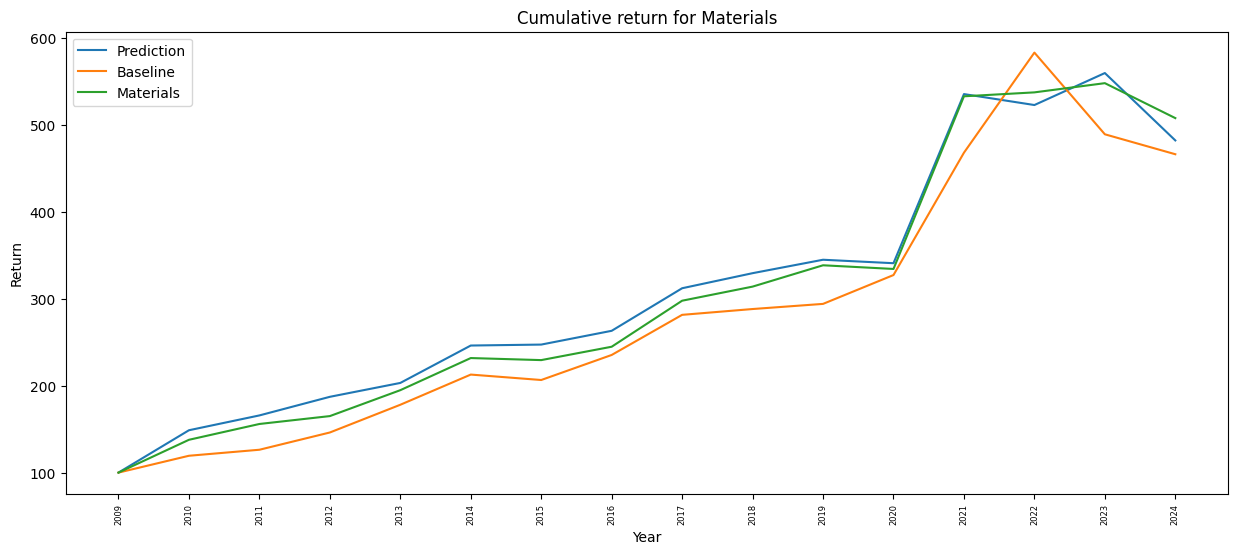

Anualized return for Materials
cumulative_return_prediction_return    10.332973
cumulative_return_baseline_return      10.102104
cumulative_return_sector_return        10.691435
dtype: float64


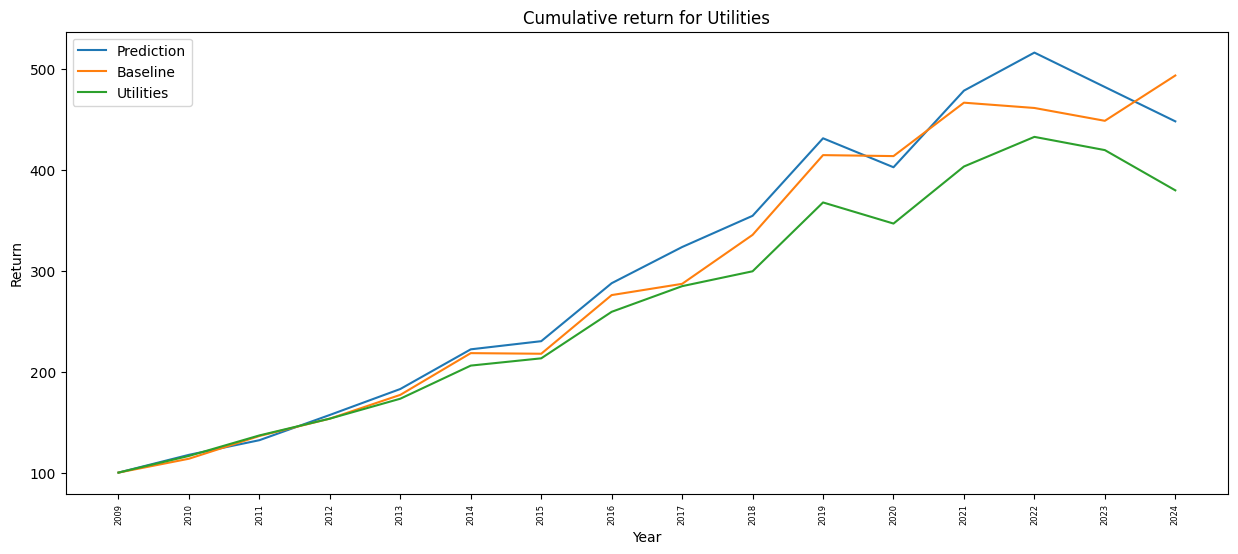

Anualized return for Utilities
cumulative_return_prediction_return     9.826274
cumulative_return_baseline_return      10.491151
cumulative_return_sector_return         8.695793
dtype: float64


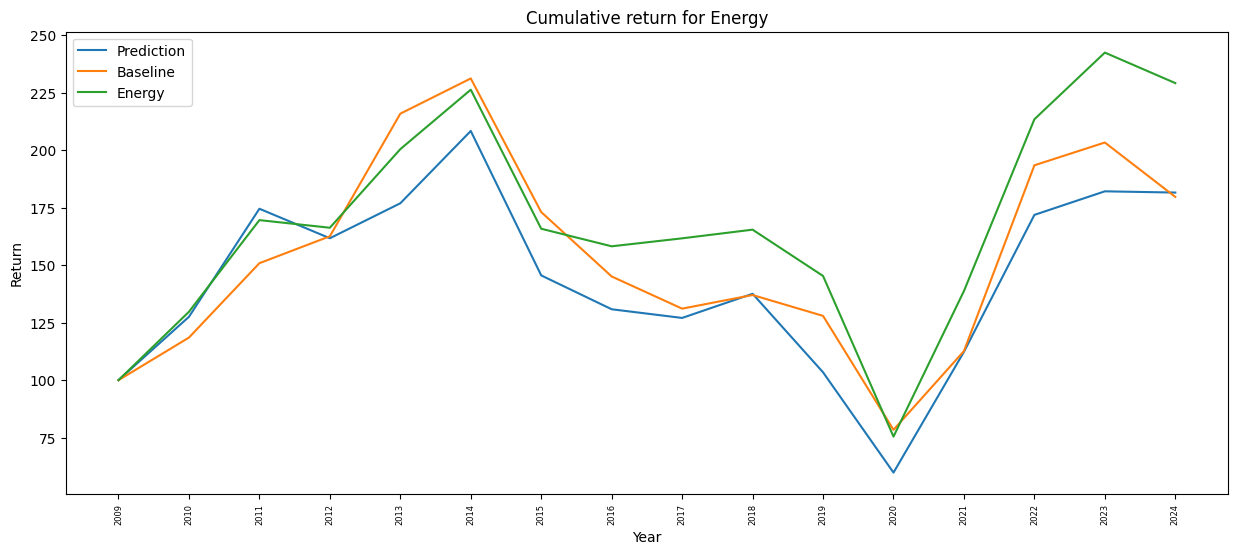

Anualized return for Energy
cumulative_return_prediction_return    3.797180
cumulative_return_baseline_return      3.729504
cumulative_return_sector_return        5.318426
dtype: float64


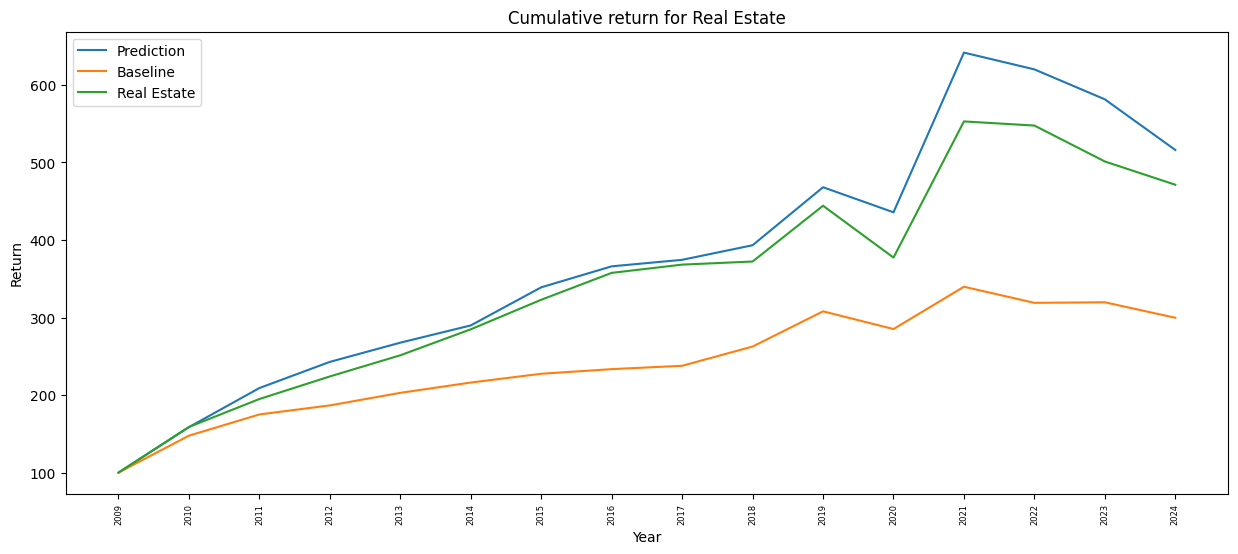

Anualized return for Real Estate
cumulative_return_prediction_return    10.801188
cumulative_return_baseline_return       7.100299
cumulative_return_sector_return        10.173296
dtype: float64


In [223]:
for sector in sector_returns['sector'].unique():
    sector_acumulative_year = acumulative_year_earnings(sector_returns[sector_returns['sector'].str.contains(sector)])
    plt.subplots(figsize=(15, 6))
    sns.lineplot(data=sector_acumulative_year, x=sector_acumulative_year.index, y='cumulative_return_prediction_return',label='Prediction')
    sns.lineplot(data=sector_acumulative_year, x=sector_acumulative_year.index, y='cumulative_return_baseline_return',label='Baseline')
    sns.lineplot(data=sector_acumulative_year, x=sector_acumulative_year.index, y='cumulative_return_sector_return',label=sector)
    plt.title(f'Cumulative return for {sector}')
    plt.xticks(rotation=90, fontsize=6)
    plt.xlabel('Year')
    plt.ylabel('Return')
    plt.show()
    
    print(f"Anualized return for {sector}")
    print(cagr(sector_acumulative_year)*100)

### Comparing the proportion of the percentage of the sectors invested in the portfolio (Case with 20 assets)

In [ ]:
df_sectors = pd.DataFrame(columns=['quarter','percentage']) 
for i in range(len(datasets)):
    quarter = unique_quarters[i+window_size] 
    df = create_results_df(df_final,predictions_list, quarter,True,'1year_price_variation')
    sectors_invested = df.sort_values('rank_pos', ascending=False).head(20)['new_sector'].value_counts(normalize=True)
    data = {'quarter':quarter,'percentage':sectors_invested}
    df_pivot = pd.DataFrame(data).reset_index()
    df_sectors = pd.concat([df_sectors,df_pivot])
df_sectors = df_sectors.groupby(['quarter','new_sector'])['percentage'].mean().reset_index()

C:\Users\ALEX\AppData\Local\Temp\ipykernel_6844\2485387780.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_sectors = pd.concat([df_sectors,df_pivot])
C:\Users\ALEX\AppData\Local\Temp\ipykernel_6844\2485387780.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sectors = df_sectors.groupby(['quarter','new_sector'])['percentage'].mean().reset_index()


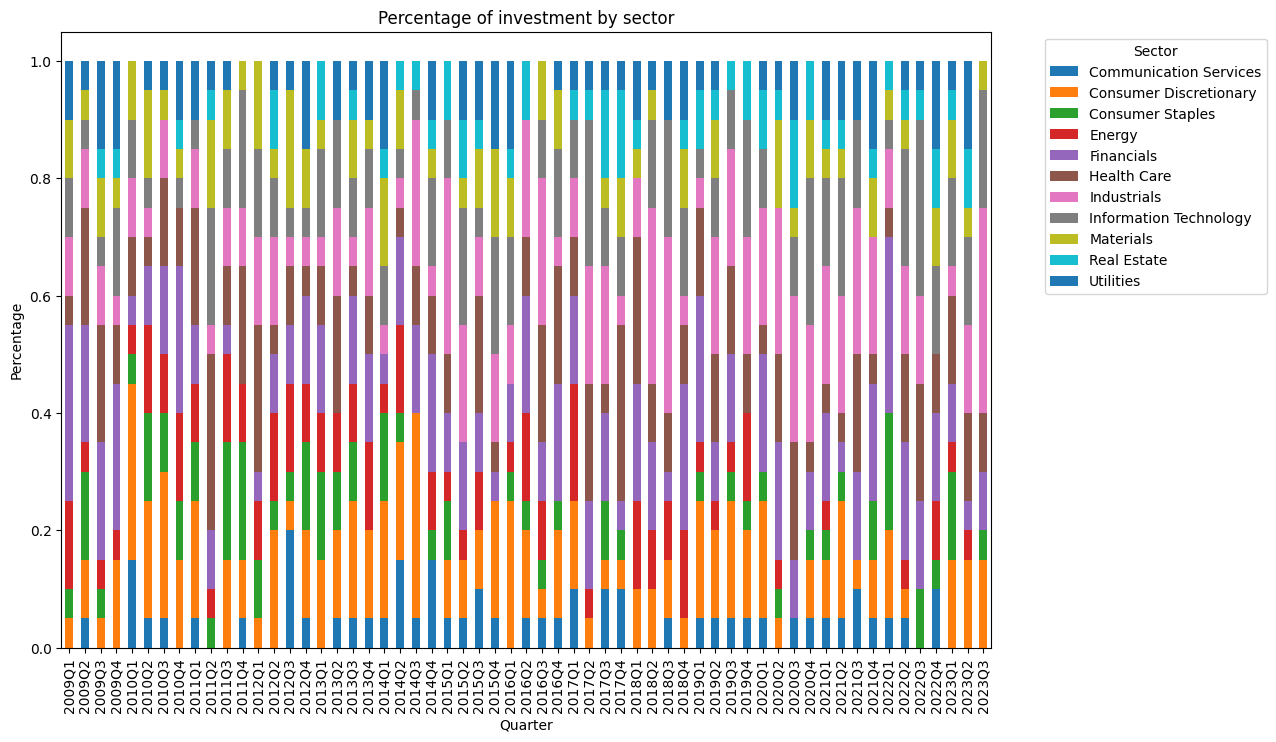

In [225]:
df_sectors.pivot(index='quarter',columns='new_sector',values='percentage').plot(
        kind="bar",
        stacked=True,
        figsize=(12, 8),)
plt.legend(title="Sector",bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Percentage of investment by sector")
plt.xlabel("Quarter")
plt.ylabel("Percentage")
plt.show()